## Neural Style Transfer using VGG19

In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt

### convert our images into 224*224 

In [2]:
def resize(path):
    basewidth = 300
    img = Image.open(path)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img.save('resized_image_style.jpg')
    return img

### style_layers 2

In [15]:
STYLE_WEIGHT = 1
CONTENT_WEIGHT = 1
STYLE_LAYERS = ['relu1_2','relu2_2']
CONTENT_LAYERS = ['relu1_2']
_vgg_params = None

def vgg_params():
    """
    read in the weights from VGG19
    """
    global _vgg_params
    if _vgg_params is None:
        _vgg_params = sio.loadmat('/Users/yanting/Downloads/imagenet-vgg-verydeep-19.mat')
    return _vgg_params

def vgg19(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4','pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    )

    weights = vgg_params()['layers'][0]
    net = input_image
    network = {}
    for i,name in enumerate(layers):
        layer_type = name[:4]
        if layer_type == 'conv':
            kernels,bias = weights[i][0][0][0][0]
            kernels = np.transpose(kernels,(1,0,2,3))
            conv = tf.nn.conv2d(net,tf.constant(kernels),strides=(1,1,1,1),padding='SAME',name=name)
            net = tf.nn.bias_add(conv,bias.reshape(-1))
            net = tf.nn.relu(net)
        elif layer_type == 'pool':
            net = tf.nn.max_pool(net,ksize=(1,2,2,1),strides=(1,2,2,1),padding='SAME')
        network[name] = net

    return network

def content_loss(target_features,content_features):
    _,height,width,channel = map(lambda i:i.value,content_features.get_shape())
    print ('content_features.get_shape() : ')
    print (content_features.get_shape())
    content_size = height * width * channel
    return tf.nn.l2_loss(target_features - content_features) / content_size

def style_loss(target_features,style_features):
    _,height,width,channel = map(lambda i:i.value,target_features.get_shape())
    print ('target_features.get_shape() : ')
    print (target_features.get_shape())
    size = height * width * channel
    target_features = tf.reshape(target_features,(-1,channel))
    target_gram = tf.matmul(tf.transpose(target_features),target_features) / size

    style_features = tf.reshape(style_features,(-1,channel))
    style_gram = tf.matmul(tf.transpose(style_features),style_features) / size

    return tf.nn.l2_loss(target_gram - style_gram) / size

def loss_function(style_image,content_image,target_image):
    style_features = vgg19([style_image])
    content_features = vgg19([content_image])
    target_features = vgg19([target_image])
    loss = 0.0
    for layer in CONTENT_LAYERS:
        loss += CONTENT_WEIGHT * content_loss(target_features[layer],content_features[layer])

    for layer in STYLE_LAYERS:
        loss += STYLE_WEIGHT * style_loss(target_features[layer],style_features[layer])

    return loss



def stylize(style_image,content_image,learning_rate=0.1,epochs=500):
    cost_list = []
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32)
    style_input = tf.constant(style_image,dtype=tf.float32)
    content_input = tf.constant(content_image, dtype=tf.float32)
    cost = loss_function(style_input,content_input,target)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.initialize_all_variables().run()
        for i in range(epochs):
            _,loss,target_image = sess.run([train_op,cost,target])
            print("iter:%d,loss:%.9f" % (i, loss))
            cost_list.append(loss)
            if (i+1) % 100 == 0:
                image = np.clip(target_image + 128,0,255).astype(np.uint8)
                Image.fromarray(image).save("/Users/yanting/Desktop/2040-final/neural_me_%d.jpg" % (i + 1))
    return cost_list

In [16]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/brown.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,100)

content_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 61, 150, 128)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:27800.054687500
iter:1,loss:27447.097656250
iter:2,loss:27072.666015625
iter:3,loss:26688.964843750
iter:4,loss:26301.146484375
iter:5,loss:25912.064453125
iter:6,loss:25523.660156250
iter:7,loss:25137.091796875
iter:8,loss:24753.207031250
iter:9,loss:24372.597656250
iter:10,loss:23995.759765625
iter:11,loss:23622.996093750
iter:12,loss:23254.683593750
iter:13,loss:22891.000000000
iter:14,loss:22532.152343750
iter:15,loss:22178.310546875
iter:16,loss:21829.609375000
iter:17,loss:21486.183593750
iter:18,loss:21148.052734375
iter:19,loss:20815.300781250
iter:20,loss:20487.970703125
iter:21,loss:20166.068359375
iter:22,loss:19849.613281250
iter:23,loss:19538.626953125
iter:24,loss:19233.056640625
iter:25,loss:18932.890625000
iter:26,loss:18638.160156250
iter:

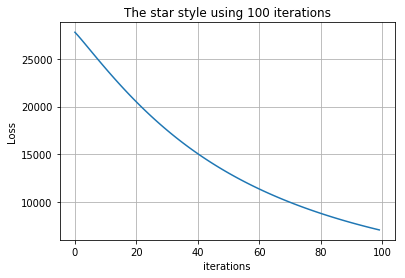

In [23]:
# loss plot
plt.plot(loss_list)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.title('The star style using 100 iterations')
plt.grid(True)

#### 500 iterations using The Starry Night style

In [24]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/brown.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,500)

content_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 61, 150, 128)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:27798.623046875
iter:1,loss:27444.597656250
iter:2,loss:27069.609375000
iter:3,loss:26685.236328125
iter:4,loss:26296.935546875
iter:5,loss:25907.482421875
iter:6,loss:25518.666015625
iter:7,loss:25131.734375000
iter:8,loss:24747.527343750
iter:9,loss:24366.628906250
iter:10,loss:23989.525390625
iter:11,loss:23616.523437500
iter:12,loss:23247.919921875
iter:13,loss:22883.982421875
iter:14,loss:22524.898437500
iter:15,loss:22170.814453125
iter:16,loss:21821.884765625
iter:17,loss:21478.195312500
iter:18,loss:21139.808593750
iter:19,loss:20806.832031250
iter:20,loss:20479.308593750
iter:21,loss:20157.216796875
iter:22,loss:19840.601562500
iter:23,loss:19529.460937500
iter:24,loss:19223.796875000
iter:25,loss:18923.568359375
iter:26,loss:18628.771484375
iter:

iter:269,loss:1927.052246094
iter:270,loss:1917.120117188
iter:271,loss:1907.287963867
iter:272,loss:1897.558471680
iter:273,loss:1887.927246094
iter:274,loss:1878.397460938
iter:275,loss:1868.964355469
iter:276,loss:1859.627563477
iter:277,loss:1850.385620117
iter:278,loss:1841.236816406
iter:279,loss:1832.179809570
iter:280,loss:1823.215942383
iter:281,loss:1814.343261719
iter:282,loss:1805.559570312
iter:283,loss:1796.867797852
iter:284,loss:1788.262695312
iter:285,loss:1779.746215820
iter:286,loss:1771.315795898
iter:287,loss:1762.971313477
iter:288,loss:1754.710693359
iter:289,loss:1746.536132812
iter:290,loss:1738.444580078
iter:291,loss:1730.437255859
iter:292,loss:1722.512451172
iter:293,loss:1714.669189453
iter:294,loss:1706.904785156
iter:295,loss:1699.222656250
iter:296,loss:1691.619018555
iter:297,loss:1684.093994141
iter:298,loss:1676.646240234
iter:299,loss:1669.274902344
iter:300,loss:1661.980957031
iter:301,loss:1654.761474609
iter:302,loss:1647.616699219
iter:303,loss:

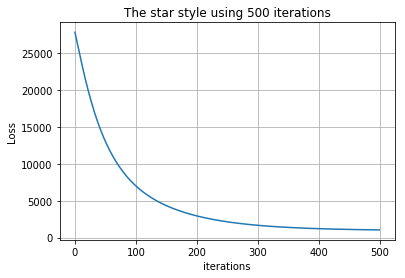

In [25]:
# loss plot
plt.plot(loss_list)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.title('The star style using 500 iterations')
plt.grid(True)

#### 500 iterations using the Picasso style to transfer panda image

In [15]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/abstract.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/panda.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,500)

content_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 84, 150, 128)
target_features.get_shape() : 
(1, 42, 75, 256)
target_features.get_shape() : 
(1, 21, 38, 512)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:373164.031250000
iter:1,loss:372726.687500000
iter:2,loss:371934.812500000
iter:3,loss:370794.687500000
iter:4,loss:369256.531250000
iter:5,loss:367297.500000000
iter:6,loss:364933.781250000
iter:7,loss:362140.625000000
iter:8,loss:358887.687500000
iter:9,loss:355164.562500000
iter:10,loss:350981.343750000
iter:11,loss:346346.500000000
iter:12,loss:341250.625000000
iter:13,loss:335729.625000000
iter:14,loss:329800.531250000
iter:15,loss:323508.468750000
iter:16,loss:316910.625000000
iter:17,loss:310045.375000000
iter:18,loss:302992.281250000
iter:19,loss:295823.750000000
iter:20,loss:288621.625000000
iter:21,loss:281460.656250000
iter:22,loss:274417.031250000
it

iter:257,loss:29067.558593750
iter:258,loss:29016.308593750
iter:259,loss:28965.503906250
iter:260,loss:28915.082031250
iter:261,loss:28865.000000000
iter:262,loss:28815.187500000
iter:263,loss:28765.759765625
iter:264,loss:28716.748046875
iter:265,loss:28668.138671875
iter:266,loss:28619.964843750
iter:267,loss:28572.119140625
iter:268,loss:28524.593750000
iter:269,loss:28477.423828125
iter:270,loss:28430.558593750
iter:271,loss:28383.984375000
iter:272,loss:28337.710937500
iter:273,loss:28291.660156250
iter:274,loss:28245.878906250
iter:275,loss:28200.437500000
iter:276,loss:28155.283203125
iter:277,loss:28110.392578125
iter:278,loss:28065.757812500
iter:279,loss:28021.410156250
iter:280,loss:27977.355468750
iter:281,loss:27933.511718750
iter:282,loss:27889.984375000
iter:283,loss:27846.750000000
iter:284,loss:27803.755859375
iter:285,loss:27760.966796875
iter:286,loss:27718.433593750
iter:287,loss:27676.224609375
iter:288,loss:27634.406250000
iter:289,loss:27592.851562500
iter:290,l

#### 500 iterations using The Starry Night style to transfer panda image

In [4]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/panda.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,500)

content_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 84, 150, 128)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:16572.912109375
iter:1,loss:16406.599609375
iter:2,loss:16221.369140625
iter:3,loss:16027.581054688
iter:4,loss:15830.364257812
iter:5,loss:15632.296875000
iter:6,loss:15434.930664062
iter:7,loss:15239.397460938
iter:8,loss:15046.484375000
iter:9,loss:14856.765625000
iter:10,loss:14670.676757812
iter:11,loss:14488.539062500
iter:12,loss:14310.593750000
iter:13,loss:14137.019531250
iter:14,loss:13967.946289062
iter:15,loss:13803.468750000
iter:16,loss:13643.598632812
iter:17,loss:13488.375000000
iter:18,loss:13337.757812500
iter:19,loss:13191.717773438
iter:20,loss:13050.211914062
iter:21,loss:12913.123046875
iter:22,loss:12780.375976562
iter:23,loss:12651.827148438
iter:24,loss:12527.388671875
iter:25,loss:12406.890625000
iter:26,loss:12290.202148438
iter:

iter:270,loss:1698.289794922
iter:271,loss:1683.726806641
iter:272,loss:1669.375732422
iter:273,loss:1655.229980469
iter:274,loss:1641.288574219
iter:275,loss:1627.546630859
iter:276,loss:1614.005249023
iter:277,loss:1600.660888672
iter:278,loss:1587.511108398
iter:279,loss:1574.556152344
iter:280,loss:1561.791015625
iter:281,loss:1549.214599609
iter:282,loss:1536.825195312
iter:283,loss:1524.619384766
iter:284,loss:1512.593505859
iter:285,loss:1500.748413086
iter:286,loss:1489.079223633
iter:287,loss:1477.586181641
iter:288,loss:1466.266235352
iter:289,loss:1455.119140625
iter:290,loss:1444.142578125
iter:291,loss:1433.330444336
iter:292,loss:1422.682128906
iter:293,loss:1412.198242188
iter:294,loss:1401.872680664
iter:295,loss:1391.704833984
iter:296,loss:1381.692626953
iter:297,loss:1371.834228516
iter:298,loss:1362.125000000
iter:299,loss:1352.566528320
iter:300,loss:1343.155029297
iter:301,loss:1333.887695312
iter:302,loss:1324.764892578
iter:303,loss:1315.781494141
iter:304,loss:

#### 500 iterations using the Ukiyo-e style

In [4]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/style.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/kyoto.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,500)

content_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 100, 150, 128)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:25324.615234375
iter:1,loss:24962.193359375
iter:2,loss:24579.433593750
iter:3,loss:24188.867187500
iter:4,loss:23795.250000000
iter:5,loss:23401.240234375
iter:6,loss:23008.556640625
iter:7,loss:22618.484375000
iter:8,loss:22231.962890625
iter:9,loss:21849.671875000
iter:10,loss:21472.085937500
iter:11,loss:21099.554687500
iter:12,loss:20732.382812500
iter:13,loss:20370.804687500
iter:14,loss:20015.037109375
iter:15,loss:19665.197265625
iter:16,loss:19321.410156250
iter:17,loss:18983.816406250
iter:18,loss:18652.437500000
iter:19,loss:18327.341796875
iter:20,loss:18008.576171875
iter:21,loss:17696.117187500
iter:22,loss:17389.988281250
iter:23,loss:17090.132812500
iter:24,loss:16796.550781250
iter:25,loss:16509.181640625
iter:26,loss:16227.987304688
iter

iter:269,loss:2312.415039062
iter:270,loss:2304.255859375
iter:271,loss:2296.162109375
iter:272,loss:2288.135009766
iter:273,loss:2280.172851562
iter:274,loss:2272.276367188
iter:275,loss:2264.442382812
iter:276,loss:2256.670410156
iter:277,loss:2248.961425781
iter:278,loss:2241.312500000
iter:279,loss:2233.724121094
iter:280,loss:2226.195800781
iter:281,loss:2218.723632812
iter:282,loss:2211.310546875
iter:283,loss:2203.954589844
iter:284,loss:2196.660400391
iter:285,loss:2189.419433594
iter:286,loss:2182.236572266
iter:287,loss:2175.111816406
iter:288,loss:2168.037597656
iter:289,loss:2161.022949219
iter:290,loss:2154.063476562
iter:291,loss:2147.155761719
iter:292,loss:2140.302490234
iter:293,loss:2133.502929688
iter:294,loss:2126.756347656
iter:295,loss:2120.063476562
iter:296,loss:2113.424560547
iter:297,loss:2106.836425781
iter:298,loss:2100.299804688
iter:299,loss:2093.815429688
iter:300,loss:2087.381347656
iter:301,loss:2080.997558594
iter:302,loss:2074.661865234
iter:303,loss:

### style_layers 3

In [3]:
STYLE_WEIGHT = 1
CONTENT_WEIGHT = 1
STYLE_LAYERS = ['relu1_2','relu2_2','relu3_2']
CONTENT_LAYERS = ['relu1_2']
_vgg_params = None

def vgg_params():
    global _vgg_params
    if _vgg_params is None:
        _vgg_params = sio.loadmat('/Users/yanting/Downloads/imagenet-vgg-verydeep-19.mat')
    return _vgg_params

def vgg19(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4','pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    )

    weights = vgg_params()['layers'][0]
    net = input_image
    network = {}
    for i,name in enumerate(layers):
        layer_type = name[:4]
        if layer_type == 'conv':
            kernels,bias = weights[i][0][0][0][0]
            kernels = np.transpose(kernels,(1,0,2,3))
            conv = tf.nn.conv2d(net,tf.constant(kernels),strides=(1,1,1,1),padding='SAME',name=name)
            net = tf.nn.bias_add(conv,bias.reshape(-1))
            net = tf.nn.relu(net)
        elif layer_type == 'pool':
            net = tf.nn.max_pool(net,ksize=(1,2,2,1),strides=(1,2,2,1),padding='SAME')
        network[name] = net

    return network

def content_loss(target_features,content_features):
    _,height,width,channel = map(lambda i:i.value,content_features.get_shape())
    print ('content_features.get_shape() : ')
    print (content_features.get_shape())
    content_size = height * width * channel
    return tf.nn.l2_loss(target_features - content_features) / content_size

def style_loss(target_features,style_features):
    _,height,width,channel = map(lambda i:i.value,target_features.get_shape())
    print ('target_features.get_shape() : ')
    print (target_features.get_shape())
    size = height * width * channel
    target_features = tf.reshape(target_features,(-1,channel))
    target_gram = tf.matmul(tf.transpose(target_features),target_features) / size

    style_features = tf.reshape(style_features,(-1,channel))
    style_gram = tf.matmul(tf.transpose(style_features),style_features) / size

    return tf.nn.l2_loss(target_gram - style_gram) / size

def loss_function(style_image,content_image,target_image):
    style_features = vgg19([style_image])
    content_features = vgg19([content_image])
    target_features = vgg19([target_image])
    loss = 0.0
    for layer in CONTENT_LAYERS:
        loss += CONTENT_WEIGHT * content_loss(target_features[layer],content_features[layer])

    for layer in STYLE_LAYERS:
        loss += STYLE_WEIGHT * style_loss(target_features[layer],style_features[layer])

    return loss



def stylize(style_image,content_image,learning_rate=0.1,epochs=500):
    cost_list = []
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32)
    style_input = tf.constant(style_image,dtype=tf.float32)
    content_input = tf.constant(content_image, dtype=tf.float32)
    cost = loss_function(style_input,content_input,target)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.initialize_all_variables().run()
        for i in range(epochs):
            _,loss,target_image = sess.run([train_op,cost,target])
            print("iter:%d,loss:%.9f" % (i, loss))
            cost_list.append(loss)
            if (i+1) % 100 == 0:
                image = np.clip(target_image + 128,0,255).astype(np.uint8)
                Image.fromarray(image).save("/Users/yanting/Desktop/2040-final/neural_me_%d.jpg" % (i + 1))
    return cost_list

#### 1000 iterations using The Starry Night style

In [4]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/brown.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 61, 150, 128)
target_features.get_shape() : 
(1, 31, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:42249.375000000
iter:1,loss:41891.164062500
iter:2,loss:41509.156250000
iter:3,loss:41114.925781250
iter:4,loss:40713.296875000
iter:5,loss:40307.003906250
iter:6,loss:39897.710937500
iter:7,loss:39486.546875000
iter:8,loss:39074.210937500
iter:9,loss:38661.234375000
iter:10,loss:38247.953125000
iter:11,loss:37834.664062500
iter:12,loss:37421.523437500
iter:13,loss:37008.710937500
iter:14,loss:36596.250000000
iter:15,loss:36184.242187500
iter:16,loss:35772.640625000
iter:17,loss:35361.425781250
iter:18,loss:34950.625000000
iter:19,loss:34540.175781250
iter:20,loss:34130.093750000
iter:21,loss:33720.304687500
iter:22,loss:33310.753906250
iter:23,loss:32901.363281250
iter:24,loss:32492.080078125
iter:25,loss:32

iter:266,loss:4195.283691406
iter:267,loss:4179.883300781
iter:268,loss:4164.589843750
iter:269,loss:4149.407226562
iter:270,loss:4134.331542969
iter:271,loss:4119.354980469
iter:272,loss:4104.480468750
iter:273,loss:4089.705566406
iter:274,loss:4075.032714844
iter:275,loss:4060.463134766
iter:276,loss:4045.994384766
iter:277,loss:4031.624511719
iter:278,loss:4017.355224609
iter:279,loss:4003.193359375
iter:280,loss:3989.142822266
iter:281,loss:3975.191162109
iter:282,loss:3961.329589844
iter:283,loss:3947.567626953
iter:284,loss:3933.898437500
iter:285,loss:3920.312988281
iter:286,loss:3906.824218750
iter:287,loss:3893.431396484
iter:288,loss:3880.140136719
iter:289,loss:3866.946044922
iter:290,loss:3853.846435547
iter:291,loss:3840.833251953
iter:292,loss:3827.911621094
iter:293,loss:3815.072998047
iter:294,loss:3802.319824219
iter:295,loss:3789.655761719
iter:296,loss:3777.085449219
iter:297,loss:3764.606933594
iter:298,loss:3752.207763672
iter:299,loss:3739.897949219
iter:300,loss:

iter:549,loss:2230.564941406
iter:550,loss:2228.247802734
iter:551,loss:2225.951171875
iter:552,loss:2223.666992188
iter:553,loss:2221.399169922
iter:554,loss:2219.147705078
iter:555,loss:2216.914062500
iter:556,loss:2214.691162109
iter:557,loss:2212.487304688
iter:558,loss:2210.299804688
iter:559,loss:2208.124267578
iter:560,loss:2205.959960938
iter:561,loss:2203.812988281
iter:562,loss:2201.679443359
iter:563,loss:2199.557373047
iter:564,loss:2197.449951172
iter:565,loss:2195.360107422
iter:566,loss:2193.282714844
iter:567,loss:2191.215820312
iter:568,loss:2189.167480469
iter:569,loss:2187.128173828
iter:570,loss:2185.100097656
iter:571,loss:2183.086669922
iter:572,loss:2181.085693359
iter:573,loss:2179.097656250
iter:574,loss:2177.119628906
iter:575,loss:2175.155273438
iter:576,loss:2173.203857422
iter:577,loss:2171.267333984
iter:578,loss:2169.341308594
iter:579,loss:2167.428222656
iter:580,loss:2165.529052734
iter:581,loss:2163.641601562
iter:582,loss:2161.765136719
iter:583,loss:

iter:832,loss:1931.835205078
iter:833,loss:1931.450073242
iter:834,loss:1931.066162109
iter:835,loss:1930.684692383
iter:836,loss:1930.305175781
iter:837,loss:1929.930053711
iter:838,loss:1929.554809570
iter:839,loss:1929.184570312
iter:840,loss:1928.816162109
iter:841,loss:1928.447143555
iter:842,loss:1928.082519531
iter:843,loss:1927.719970703
iter:844,loss:1927.358154297
iter:845,loss:1926.999755859
iter:846,loss:1926.643676758
iter:847,loss:1926.286865234
iter:848,loss:1925.934204102
iter:849,loss:1925.585205078
iter:850,loss:1925.237304688
iter:851,loss:1924.890625000
iter:852,loss:1924.547607422
iter:853,loss:1924.204711914
iter:854,loss:1923.866699219
iter:855,loss:1923.528686523
iter:856,loss:1923.192626953
iter:857,loss:1922.857910156
iter:858,loss:1922.525878906
iter:859,loss:1922.196044922
iter:860,loss:1921.865844727
iter:861,loss:1921.542480469
iter:862,loss:1921.220703125
iter:863,loss:1920.895385742
iter:864,loss:1920.575195312
iter:865,loss:1920.256347656
iter:866,loss:

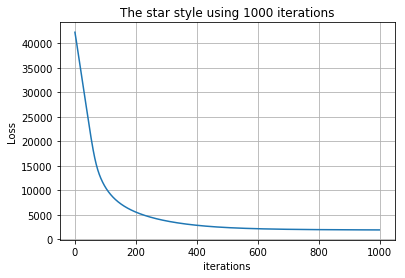

In [5]:
# loss plot
plt.plot(loss_list)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.title('The star style using 1000 iterations')
plt.grid(True)

#### 1000 iterations using the  Ukiyo-e style

In [7]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/style.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/kyoto.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 100, 150, 128)
target_features.get_shape() : 
(1, 50, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:42189.406250000
iter:1,loss:41825.250000000
iter:2,loss:41438.085937500
iter:3,loss:41040.390625000
iter:4,loss:40636.847656250
iter:5,loss:40230.109375000
iter:6,loss:39822.046875000
iter:7,loss:39413.785156250
iter:8,loss:39006.289062500
iter:9,loss:38600.062500000
iter:10,loss:38195.546875000
iter:11,loss:37793.011718750
iter:12,loss:37392.625000000
iter:13,loss:36994.609375000
iter:14,loss:36598.960937500
iter:15,loss:36205.812500000
iter:16,loss:35815.136718750
iter:17,loss:35427.035156250
iter:18,loss:35041.347656250
iter:19,loss:34658.101562500
iter:20,loss:34277.203125000
iter:21,loss:33898.613281250
iter:22,loss:33522.246093750
iter:23,loss:33148.023437500
iter:24,loss:32775.824218750
iter:25,loss:3

iter:265,loss:5953.883300781
iter:266,loss:5939.381835938
iter:267,loss:5924.976074219
iter:268,loss:5910.681640625
iter:269,loss:5896.471191406
iter:270,loss:5882.355957031
iter:271,loss:5868.341308594
iter:272,loss:5854.425781250
iter:273,loss:5840.605468750
iter:274,loss:5826.876464844
iter:275,loss:5813.252929688
iter:276,loss:5799.715820312
iter:277,loss:5786.267578125
iter:278,loss:5772.905273438
iter:279,loss:5759.622558594
iter:280,loss:5746.429687500
iter:281,loss:5733.317382812
iter:282,loss:5720.294433594
iter:283,loss:5707.359375000
iter:284,loss:5694.515625000
iter:285,loss:5681.747070312
iter:286,loss:5669.059082031
iter:287,loss:5656.456054688
iter:288,loss:5643.936523438
iter:289,loss:5631.493164062
iter:290,loss:5619.141113281
iter:291,loss:5606.872558594
iter:292,loss:5594.690917969
iter:293,loss:5582.585937500
iter:294,loss:5570.557617188
iter:295,loss:5558.610351562
iter:296,loss:5546.745117188
iter:297,loss:5534.958007812
iter:298,loss:5523.246093750
iter:299,loss:

iter:548,loss:4058.123046875
iter:549,loss:4055.877929688
iter:550,loss:4053.647460938
iter:551,loss:4051.433593750
iter:552,loss:4049.236572266
iter:553,loss:4047.049316406
iter:554,loss:4044.884765625
iter:555,loss:4042.735351562
iter:556,loss:4040.593505859
iter:557,loss:4038.467041016
iter:558,loss:4036.355224609
iter:559,loss:4034.254882812
iter:560,loss:4032.169921875
iter:561,loss:4030.087890625
iter:562,loss:4028.022460938
iter:563,loss:4025.966796875
iter:564,loss:4023.926513672
iter:565,loss:4021.894775391
iter:566,loss:4019.878417969
iter:567,loss:4017.870117188
iter:568,loss:4015.877197266
iter:569,loss:4013.895996094
iter:570,loss:4011.931152344
iter:571,loss:4009.976074219
iter:572,loss:4008.037109375
iter:573,loss:4006.111816406
iter:574,loss:4004.197265625
iter:575,loss:4002.297851562
iter:576,loss:4000.414062500
iter:577,loss:3998.543457031
iter:578,loss:3996.684814453
iter:579,loss:3994.839599609
iter:580,loss:3993.003417969
iter:581,loss:3991.180908203
iter:582,loss:

iter:831,loss:3753.886230469
iter:832,loss:3753.406738281
iter:833,loss:3752.929199219
iter:834,loss:3752.447509766
iter:835,loss:3751.971435547
iter:836,loss:3751.495117188
iter:837,loss:3751.019775391
iter:838,loss:3750.547363281
iter:839,loss:3750.074951172
iter:840,loss:3749.604492188
iter:841,loss:3749.131347656
iter:842,loss:3748.661376953
iter:843,loss:3748.200439453
iter:844,loss:3747.730957031
iter:845,loss:3747.271484375
iter:846,loss:3746.808593750
iter:847,loss:3746.346191406
iter:848,loss:3745.885742188
iter:849,loss:3745.427734375
iter:850,loss:3744.970703125
iter:851,loss:3744.522460938
iter:852,loss:3744.073242188
iter:853,loss:3743.627441406
iter:854,loss:3743.183105469
iter:855,loss:3742.743164062
iter:856,loss:3742.305175781
iter:857,loss:3741.869628906
iter:858,loss:3741.433593750
iter:859,loss:3741.005859375
iter:860,loss:3740.577636719
iter:861,loss:3740.149169922
iter:862,loss:3739.725585938
iter:863,loss:3739.302246094
iter:864,loss:3738.886230469
iter:865,loss:

#### using star style and portrait image

In [8]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/ycy.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,500)

content_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 84, 150, 128)
target_features.get_shape() : 
(1, 42, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:50665.531250000
iter:1,loss:50160.687500000
iter:2,loss:49645.570312500
iter:3,loss:49126.218750000
iter:4,loss:48604.261718750
iter:5,loss:48080.644531250
iter:6,loss:47556.402343750
iter:7,loss:47032.773437500
iter:8,loss:46510.609375000
iter:9,loss:45990.652343750
iter:10,loss:45473.277343750
iter:11,loss:44958.835937500
iter:12,loss:44447.585937500
iter:13,loss:43939.652343750
iter:14,loss:43435.257812500
iter:15,loss:42934.527343750
iter:16,loss:42437.558593750
iter:17,loss:41944.453125000
iter:18,loss:41455.203125000
iter:19,loss:40969.996093750
iter:20,loss:40488.746093750
iter:21,loss:40011.613281250
iter:22,loss:39538.476562500
iter:23,loss:39069.476562500
iter:24,loss:38604.566406250
iter:25,loss:38

iter:265,loss:4160.477050781
iter:266,loss:4145.278320312
iter:267,loss:4130.270996094
iter:268,loss:4115.453125000
iter:269,loss:4100.822265625
iter:270,loss:4086.380859375
iter:271,loss:4072.118164062
iter:272,loss:4058.031250000
iter:273,loss:4044.105712891
iter:274,loss:4030.353271484
iter:275,loss:4016.766357422
iter:276,loss:4003.357421875
iter:277,loss:3990.111083984
iter:278,loss:3977.035644531
iter:279,loss:3964.115722656
iter:280,loss:3951.347167969
iter:281,loss:3938.729736328
iter:282,loss:3926.256347656
iter:283,loss:3913.933837891
iter:284,loss:3901.758300781
iter:285,loss:3889.725341797
iter:286,loss:3877.837646484
iter:287,loss:3866.091552734
iter:288,loss:3854.481933594
iter:289,loss:3843.007324219
iter:290,loss:3831.674804688
iter:291,loss:3820.476806641
iter:292,loss:3809.414306641
iter:293,loss:3798.477539062
iter:294,loss:3787.664794922
iter:295,loss:3776.976562500
iter:296,loss:3766.405761719
iter:297,loss:3755.955566406
iter:298,loss:3745.626464844
iter:299,loss:

#### 1000 iterations using The Starry Night style to transfer panda image

In [8]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/panda.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 84, 150, 128)
target_features.get_shape() : 
(1, 42, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:22381.699218750
iter:1,loss:22211.402343750
iter:2,loss:22021.035156250
iter:3,loss:21820.802734375
iter:4,loss:21615.544921875
iter:5,loss:21407.724609375
iter:6,loss:21198.746093750
iter:7,loss:20989.623046875
iter:8,loss:20781.007812500
iter:9,loss:20573.359375000
iter:10,loss:20367.066406250
iter:11,loss:20162.306640625
iter:12,loss:19959.251953125
iter:13,loss:19758.009765625
iter:14,loss:19558.650390625
iter:15,loss:19361.171875000
iter:16,loss:19165.572265625
iter:17,loss:18971.791015625
iter:18,loss:18779.757812500
iter:19,loss:18589.398437500
iter:20,loss:18400.572265625
iter:21,loss:18213.193359375
iter:22,loss:18027.095703125
iter:23,loss:17842.201171875
iter:24,loss:17658.388671875
iter:25,loss:17

iter:266,loss:3923.288085938
iter:267,loss:3900.712890625
iter:268,loss:3878.323974609
iter:269,loss:3856.125976562
iter:270,loss:3834.107666016
iter:271,loss:3812.274658203
iter:272,loss:3790.622802734
iter:273,loss:3769.154541016
iter:274,loss:3747.866943359
iter:275,loss:3726.761230469
iter:276,loss:3705.837158203
iter:277,loss:3685.096679688
iter:278,loss:3664.541992188
iter:279,loss:3644.163330078
iter:280,loss:3623.961181641
iter:281,loss:3603.942138672
iter:282,loss:3584.105468750
iter:283,loss:3564.441894531
iter:284,loss:3544.956054688
iter:285,loss:3525.647460938
iter:286,loss:3506.518310547
iter:287,loss:3487.570068359
iter:288,loss:3468.788818359
iter:289,loss:3450.177734375
iter:290,loss:3431.741699219
iter:291,loss:3413.482910156
iter:292,loss:3395.391845703
iter:293,loss:3377.467041016
iter:294,loss:3359.706542969
iter:295,loss:3342.117187500
iter:296,loss:3324.692382812
iter:297,loss:3307.424560547
iter:298,loss:3290.326171875
iter:299,loss:3273.389404297
iter:300,loss:

iter:549,loss:1856.767333984
iter:550,loss:1855.811157227
iter:551,loss:1854.864257812
iter:552,loss:1853.927246094
iter:553,loss:1853.000732422
iter:554,loss:1852.081787109
iter:555,loss:1851.168701172
iter:556,loss:1850.265380859
iter:557,loss:1849.369873047
iter:558,loss:1848.482421875
iter:559,loss:1847.603881836
iter:560,loss:1846.730712891
iter:561,loss:1845.866455078
iter:562,loss:1845.008789062
iter:563,loss:1844.160278320
iter:564,loss:1843.320800781
iter:565,loss:1842.488769531
iter:566,loss:1841.664550781
iter:567,loss:1840.847167969
iter:568,loss:1840.037841797
iter:569,loss:1839.236328125
iter:570,loss:1838.443603516
iter:571,loss:1837.659423828
iter:572,loss:1836.884033203
iter:573,loss:1836.112304688
iter:574,loss:1835.348876953
iter:575,loss:1834.593750000
iter:576,loss:1833.847412109
iter:577,loss:1833.106201172
iter:578,loss:1832.372192383
iter:579,loss:1831.645385742
iter:580,loss:1830.926025391
iter:581,loss:1830.215698242
iter:582,loss:1829.511962891
iter:583,loss:

iter:832,loss:1748.137451172
iter:833,loss:1747.983276367
iter:834,loss:1747.831054688
iter:835,loss:1747.677612305
iter:836,loss:1747.524169922
iter:837,loss:1747.372070312
iter:838,loss:1747.220581055
iter:839,loss:1747.066284180
iter:840,loss:1746.912597656
iter:841,loss:1746.761474609
iter:842,loss:1746.609619141
iter:843,loss:1746.461791992
iter:844,loss:1746.312011719
iter:845,loss:1746.161376953
iter:846,loss:1746.016723633
iter:847,loss:1745.869628906
iter:848,loss:1745.725585938
iter:849,loss:1745.583007812
iter:850,loss:1745.440429688
iter:851,loss:1745.300537109
iter:852,loss:1745.159179688
iter:853,loss:1745.019653320
iter:854,loss:1744.880615234
iter:855,loss:1744.739746094
iter:856,loss:1744.603271484
iter:857,loss:1744.465209961
iter:858,loss:1744.329711914
iter:859,loss:1744.196777344
iter:860,loss:1744.062377930
iter:861,loss:1743.931152344
iter:862,loss:1743.797851562
iter:863,loss:1743.665893555
iter:864,loss:1743.533325195
iter:865,loss:1743.401489258
iter:866,loss:

### style_layers 4

In [9]:
STYLE_WEIGHT = 1
CONTENT_WEIGHT = 1
STYLE_LAYERS = ['relu1_2','relu2_2','relu3_2','relu4_2']
CONTENT_LAYERS = ['relu1_2']
_vgg_params = None

def vgg_params():
    global _vgg_params
    if _vgg_params is None:
        _vgg_params = sio.loadmat('/Users/yanting/Downloads/imagenet-vgg-verydeep-19.mat')
    return _vgg_params

def vgg19(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4','pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    )

    weights = vgg_params()['layers'][0]
    net = input_image
    network = {}
    for i,name in enumerate(layers):
        layer_type = name[:4]
        if layer_type == 'conv':
            kernels,bias = weights[i][0][0][0][0]
            kernels = np.transpose(kernels,(1,0,2,3))
            conv = tf.nn.conv2d(net,tf.constant(kernels),strides=(1,1,1,1),padding='SAME',name=name)
            net = tf.nn.bias_add(conv,bias.reshape(-1))
            net = tf.nn.relu(net)
        elif layer_type == 'pool':
            net = tf.nn.max_pool(net,ksize=(1,2,2,1),strides=(1,2,2,1),padding='SAME')
        network[name] = net

    return network

def content_loss(target_features,content_features):
    _,height,width,channel = map(lambda i:i.value,content_features.get_shape())
    print ('content_features.get_shape() : ')
    print (content_features.get_shape())
    content_size = height * width * channel
    return tf.nn.l2_loss(target_features - content_features) / content_size

def style_loss(target_features,style_features):
    _,height,width,channel = map(lambda i:i.value,target_features.get_shape())
    print ('target_features.get_shape() : ')
    print (target_features.get_shape())
    size = height * width * channel
    target_features = tf.reshape(target_features,(-1,channel))
    target_gram = tf.matmul(tf.transpose(target_features),target_features) / size

    style_features = tf.reshape(style_features,(-1,channel))
    style_gram = tf.matmul(tf.transpose(style_features),style_features) / size

    return tf.nn.l2_loss(target_gram - style_gram) / size

def loss_function(style_image,content_image,target_image):
    style_features = vgg19([style_image])
    content_features = vgg19([content_image])
    target_features = vgg19([target_image])
    loss = 0.0
    for layer in CONTENT_LAYERS:
        loss += CONTENT_WEIGHT * content_loss(target_features[layer],content_features[layer])

    for layer in STYLE_LAYERS:
        loss += STYLE_WEIGHT * style_loss(target_features[layer],style_features[layer])

    return loss



def stylize(style_image,content_image,learning_rate=0.1,epochs=500):
    cost_list = []
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32)
    style_input = tf.constant(style_image,dtype=tf.float32)
    content_input = tf.constant(content_image, dtype=tf.float32)
    cost = loss_function(style_input,content_input,target)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.initialize_all_variables().run()
        for i in range(epochs):
            _,loss,target_image = sess.run([train_op,cost,target])
            cost_list.append(loss)
            print("iter:%d,loss:%.9f" % (i, loss))
            if (i+1) % 100 == 0:
                image = np.clip(target_image + 128,0,255).astype(np.uint8)
                Image.fromarray(image).save("/Users/yanting/Desktop/2040-final/neural_me_%d.jpg" % (i + 1))
    return cost_list

#### 2500 iterations using the star style

In [10]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/brown.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,2500)

content_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 61, 150, 128)
target_features.get_shape() : 
(1, 31, 75, 256)
target_features.get_shape() : 
(1, 16, 38, 512)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:526229.875000000
iter:1,loss:525554.062500000
iter:2,loss:524447.187500000
iter:3,loss:522909.718750000
iter:4,loss:520938.500000000
iter:5,loss:518511.625000000
iter:6,loss:515601.406250000
iter:7,loss:512168.250000000
iter:8,loss:508204.625000000
iter:9,loss:503682.937500000
iter:10,loss:498585.281250000
iter:11,loss:492911.125000000
iter:12,loss:486668.000000000
iter:13,loss:479856.718750000
iter:14,loss:472497.812500000
iter:15,loss:464631.437500000
iter:16,loss:456285.656250000
iter:17,loss:447493.625000000
iter:18,loss:438313.687500000
iter:19,loss:428799.312500000
iter:20,loss:419019.000000000
iter:21,loss:409051.812500000
iter:22,loss:398970.750000000
it

iter:257,loss:33360.515625000
iter:258,loss:33289.371093750
iter:259,loss:33218.761718750
iter:260,loss:33148.734375000
iter:261,loss:33079.042968750
iter:262,loss:33009.773437500
iter:263,loss:32940.945312500
iter:264,loss:32872.597656250
iter:265,loss:32804.660156250
iter:266,loss:32737.230468750
iter:267,loss:32670.224609375
iter:268,loss:32603.636718750
iter:269,loss:32537.480468750
iter:270,loss:32471.746093750
iter:271,loss:32406.437500000
iter:272,loss:32341.449218750
iter:273,loss:32276.792968750
iter:274,loss:32212.589843750
iter:275,loss:32148.839843750
iter:276,loss:32085.445312500
iter:277,loss:32022.500000000
iter:278,loss:31960.019531250
iter:279,loss:31897.824218750
iter:280,loss:31836.007812500
iter:281,loss:31774.468750000
iter:282,loss:31713.281250000
iter:283,loss:31652.470703125
iter:284,loss:31591.957031250
iter:285,loss:31531.757812500
iter:286,loss:31471.910156250
iter:287,loss:31412.410156250
iter:288,loss:31353.265625000
iter:289,loss:31294.472656250
iter:290,l

iter:531,loss:22624.080078125
iter:532,loss:22600.955078125
iter:533,loss:22577.925781250
iter:534,loss:22554.964843750
iter:535,loss:22532.054687500
iter:536,loss:22509.203125000
iter:537,loss:22486.414062500
iter:538,loss:22463.710937500
iter:539,loss:22441.074218750
iter:540,loss:22418.519531250
iter:541,loss:22396.023437500
iter:542,loss:22373.654296875
iter:543,loss:22351.373046875
iter:544,loss:22329.169921875
iter:545,loss:22307.064453125
iter:546,loss:22284.996093750
iter:547,loss:22262.990234375
iter:548,loss:22241.044921875
iter:549,loss:22219.193359375
iter:550,loss:22197.406250000
iter:551,loss:22175.664062500
iter:552,loss:22153.964843750
iter:553,loss:22132.302734375
iter:554,loss:22110.714843750
iter:555,loss:22089.181640625
iter:556,loss:22067.742187500
iter:557,loss:22046.369140625
iter:558,loss:22025.085937500
iter:559,loss:22003.863281250
iter:560,loss:21982.689453125
iter:561,loss:21961.605468750
iter:562,loss:21940.583984375
iter:563,loss:21919.640625000
iter:564,l

iter:805,loss:17968.556640625
iter:806,loss:17955.626953125
iter:807,loss:17942.722656250
iter:808,loss:17929.832031250
iter:809,loss:17916.949218750
iter:810,loss:17904.093750000
iter:811,loss:17891.242187500
iter:812,loss:17878.396484375
iter:813,loss:17865.587890625
iter:814,loss:17852.800781250
iter:815,loss:17840.042968750
iter:816,loss:17827.281250000
iter:817,loss:17814.554687500
iter:818,loss:17801.849609375
iter:819,loss:17789.150390625
iter:820,loss:17776.500000000
iter:821,loss:17763.871093750
iter:822,loss:17751.253906250
iter:823,loss:17738.646484375
iter:824,loss:17726.066406250
iter:825,loss:17713.488281250
iter:826,loss:17700.923828125
iter:827,loss:17688.394531250
iter:828,loss:17675.894531250
iter:829,loss:17663.410156250
iter:830,loss:17650.941406250
iter:831,loss:17638.500000000
iter:832,loss:17626.093750000
iter:833,loss:17613.689453125
iter:834,loss:17601.312500000
iter:835,loss:17588.962890625
iter:836,loss:17576.667968750
iter:837,loss:17564.402343750
iter:838,l

iter:1076,loss:15162.119140625
iter:1077,loss:15153.923828125
iter:1078,loss:15145.750976562
iter:1079,loss:15137.586914062
iter:1080,loss:15129.447265625
iter:1081,loss:15121.328125000
iter:1082,loss:15113.207031250
iter:1083,loss:15105.085937500
iter:1084,loss:15096.987304688
iter:1085,loss:15088.884765625
iter:1086,loss:15080.784179688
iter:1087,loss:15072.698242188
iter:1088,loss:15064.589843750
iter:1089,loss:15056.499023438
iter:1090,loss:15048.435546875
iter:1091,loss:15040.374023438
iter:1092,loss:15032.345703125
iter:1093,loss:15024.344726562
iter:1094,loss:15016.342773438
iter:1095,loss:15008.367187500
iter:1096,loss:15000.405273438
iter:1097,loss:14992.448242188
iter:1098,loss:14984.503906250
iter:1099,loss:14976.562500000
iter:1100,loss:14968.626953125
iter:1101,loss:14960.696289062
iter:1102,loss:14952.776367188
iter:1103,loss:14944.875976562
iter:1104,loss:14936.967773438
iter:1105,loss:14929.055664062
iter:1106,loss:14921.162109375
iter:1107,loss:14913.250976562
iter:110

iter:1341,loss:13320.843750000
iter:1342,loss:13315.045898438
iter:1343,loss:13309.264648438
iter:1344,loss:13303.484375000
iter:1345,loss:13297.718750000
iter:1346,loss:13291.967773438
iter:1347,loss:13286.224609375
iter:1348,loss:13280.500000000
iter:1349,loss:13274.776367188
iter:1350,loss:13269.072265625
iter:1351,loss:13263.367187500
iter:1352,loss:13257.683593750
iter:1353,loss:13251.996093750
iter:1354,loss:13246.333007812
iter:1355,loss:13240.671875000
iter:1356,loss:13235.009765625
iter:1357,loss:13229.362304688
iter:1358,loss:13223.726562500
iter:1359,loss:13218.090820312
iter:1360,loss:13212.471679688
iter:1361,loss:13206.859375000
iter:1362,loss:13201.261718750
iter:1363,loss:13195.663085938
iter:1364,loss:13190.068359375
iter:1365,loss:13184.506835938
iter:1366,loss:13178.939453125
iter:1367,loss:13173.384765625
iter:1368,loss:13167.844726562
iter:1369,loss:13162.296875000
iter:1370,loss:13156.775390625
iter:1371,loss:13151.251953125
iter:1372,loss:13145.738281250
iter:137

iter:1606,loss:12015.418945312
iter:1607,loss:12011.183593750
iter:1608,loss:12006.956054688
iter:1609,loss:12002.748046875
iter:1610,loss:11998.533203125
iter:1611,loss:11994.344726562
iter:1612,loss:11990.152343750
iter:1613,loss:11985.967773438
iter:1614,loss:11981.785156250
iter:1615,loss:11977.610351562
iter:1616,loss:11973.437500000
iter:1617,loss:11969.276367188
iter:1618,loss:11965.111328125
iter:1619,loss:11960.945312500
iter:1620,loss:11956.791015625
iter:1621,loss:11952.636718750
iter:1622,loss:11948.476562500
iter:1623,loss:11944.328125000
iter:1624,loss:11940.197265625
iter:1625,loss:11936.066406250
iter:1626,loss:11931.941406250
iter:1627,loss:11927.816406250
iter:1628,loss:11923.699218750
iter:1629,loss:11919.587890625
iter:1630,loss:11915.468750000
iter:1631,loss:11911.351562500
iter:1632,loss:11907.245117188
iter:1633,loss:11903.135742188
iter:1634,loss:11899.035156250
iter:1635,loss:11894.924804688
iter:1636,loss:11890.830078125
iter:1637,loss:11886.737304688
iter:163

iter:1871,loss:11031.479492188
iter:1872,loss:11028.197265625
iter:1873,loss:11024.914062500
iter:1874,loss:11021.648437500
iter:1875,loss:11018.386718750
iter:1876,loss:11015.126953125
iter:1877,loss:11011.875000000
iter:1878,loss:11008.628906250
iter:1879,loss:11005.381835938
iter:1880,loss:11002.170898438
iter:1881,loss:10998.946289062
iter:1882,loss:10995.735351562
iter:1883,loss:10992.518554688
iter:1884,loss:10989.318359375
iter:1885,loss:10986.115234375
iter:1886,loss:10982.905273438
iter:1887,loss:10979.726562500
iter:1888,loss:10976.539062500
iter:1889,loss:10973.353515625
iter:1890,loss:10970.172851562
iter:1891,loss:10967.001953125
iter:1892,loss:10963.821289062
iter:1893,loss:10960.649414062
iter:1894,loss:10957.480468750
iter:1895,loss:10954.309570312
iter:1896,loss:10951.135742188
iter:1897,loss:10947.965820312
iter:1898,loss:10944.807617188
iter:1899,loss:10941.644531250
iter:1900,loss:10938.482421875
iter:1901,loss:10935.328125000
iter:1902,loss:10932.185546875
iter:190

iter:2136,loss:10246.763671875
iter:2137,loss:10244.081054688
iter:2138,loss:10241.393554688
iter:2139,loss:10238.713867188
iter:2140,loss:10236.030273438
iter:2141,loss:10233.357421875
iter:2142,loss:10230.688476562
iter:2143,loss:10228.006835938
iter:2144,loss:10225.335937500
iter:2145,loss:10222.671875000
iter:2146,loss:10219.990234375
iter:2147,loss:10217.326171875
iter:2148,loss:10214.671875000
iter:2149,loss:10212.017578125
iter:2150,loss:10209.363281250
iter:2151,loss:10206.717773438
iter:2152,loss:10204.060546875
iter:2153,loss:10201.423828125
iter:2154,loss:10198.785156250
iter:2155,loss:10196.158203125
iter:2156,loss:10193.527343750
iter:2157,loss:10190.903320312
iter:2158,loss:10188.279296875
iter:2159,loss:10185.658203125
iter:2160,loss:10183.041015625
iter:2161,loss:10180.416992188
iter:2162,loss:10177.806640625
iter:2163,loss:10175.198242188
iter:2164,loss:10172.593750000
iter:2165,loss:10169.986328125
iter:2166,loss:10167.383789062
iter:2167,loss:10164.788085938
iter:216

iter:2406,loss:9613.525390625
iter:2407,loss:9611.492187500
iter:2408,loss:9609.466796875
iter:2409,loss:9607.437500000
iter:2410,loss:9605.390625000
iter:2411,loss:9603.362304688
iter:2412,loss:9601.336914062
iter:2413,loss:9599.328125000
iter:2414,loss:9597.320312500
iter:2415,loss:9595.291015625
iter:2416,loss:9593.284179688
iter:2417,loss:9591.270507812
iter:2418,loss:9589.267578125
iter:2419,loss:9587.244140625
iter:2420,loss:9585.240234375
iter:2421,loss:9583.226562500
iter:2422,loss:9581.218750000
iter:2423,loss:9579.228515625
iter:2424,loss:9577.230468750
iter:2425,loss:9575.235351562
iter:2426,loss:9573.264648438
iter:2427,loss:9571.276367188
iter:2428,loss:9569.285156250
iter:2429,loss:9567.308593750
iter:2430,loss:9565.330078125
iter:2431,loss:9563.342773438
iter:2432,loss:9561.365234375
iter:2433,loss:9559.388671875
iter:2434,loss:9557.419921875
iter:2435,loss:9555.441406250
iter:2436,loss:9553.458007812
iter:2437,loss:9551.480468750
iter:2438,loss:9549.511718750
iter:2439,

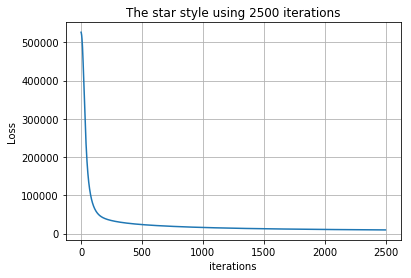

In [11]:
# loss plot
plt.plot(loss_list)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.title('The star style using 2500 iterations')
plt.grid(True)

#### 2500 iterations using the Ukiyo-e style

In [11]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/style.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/kyoto.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,2500)

content_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 100, 150, 128)
target_features.get_shape() : 
(1, 50, 75, 256)
target_features.get_shape() : 
(1, 25, 38, 512)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:596162.062500000
iter:1,loss:595520.312500000
iter:2,loss:594501.750000000
iter:3,loss:593052.875000000
iter:4,loss:591151.750000000
iter:5,loss:588773.750000000
iter:6,loss:585890.750000000
iter:7,loss:582485.687500000
iter:8,loss:578529.000000000
iter:9,loss:574006.250000000
iter:10,loss:568899.562500000
iter:11,loss:563202.000000000
iter:12,loss:556921.875000000
iter:13,loss:550076.812500000
iter:14,loss:542685.437500000
iter:15,loss:534774.625000000
iter:16,loss:526386.312500000
iter:17,loss:517572.625000000
iter:18,loss:508390.562500000
iter:19,loss:498920.406250000
iter:20,loss:489240.562500000
iter:21,loss:479429.625000000
iter:22,loss:469560.812500000
i

iter:256,loss:40214.769531250
iter:257,loss:40112.742187500
iter:258,loss:40011.710937500
iter:259,loss:39911.621093750
iter:260,loss:39812.433593750
iter:261,loss:39714.242187500
iter:262,loss:39617.085937500
iter:263,loss:39520.742187500
iter:264,loss:39425.164062500
iter:265,loss:39330.406250000
iter:266,loss:39236.468750000
iter:267,loss:39143.382812500
iter:268,loss:39051.140625000
iter:269,loss:38959.867187500
iter:270,loss:38869.472656250
iter:271,loss:38779.882812500
iter:272,loss:38691.269531250
iter:273,loss:38603.621093750
iter:274,loss:38516.531250000
iter:275,loss:38430.214843750
iter:276,loss:38344.609375000
iter:277,loss:38259.703125000
iter:278,loss:38175.511718750
iter:279,loss:38092.058593750
iter:280,loss:38009.289062500
iter:281,loss:37927.136718750
iter:282,loss:37845.585937500
iter:283,loss:37764.707031250
iter:284,loss:37684.574218750
iter:285,loss:37605.156250000
iter:286,loss:37526.406250000
iter:287,loss:37448.226562500
iter:288,loss:37370.644531250
iter:289,l

iter:530,loss:27245.144531250
iter:531,loss:27219.976562500
iter:532,loss:27194.843750000
iter:533,loss:27169.785156250
iter:534,loss:27144.787109375
iter:535,loss:27119.884765625
iter:536,loss:27095.060546875
iter:537,loss:27070.285156250
iter:538,loss:27045.580078125
iter:539,loss:27020.945312500
iter:540,loss:26996.376953125
iter:541,loss:26971.900390625
iter:542,loss:26947.494140625
iter:543,loss:26923.158203125
iter:544,loss:26898.882812500
iter:545,loss:26874.687500000
iter:546,loss:26850.566406250
iter:547,loss:26826.492187500
iter:548,loss:26802.466796875
iter:549,loss:26778.474609375
iter:550,loss:26754.546875000
iter:551,loss:26730.667968750
iter:552,loss:26706.820312500
iter:553,loss:26682.996093750
iter:554,loss:26659.242187500
iter:555,loss:26635.535156250
iter:556,loss:26611.851562500
iter:557,loss:26588.201171875
iter:558,loss:26564.582031250
iter:559,loss:26541.041015625
iter:560,loss:26517.546875000
iter:561,loss:26494.107421875
iter:562,loss:26470.712890625
iter:563,l

iter:804,loss:22090.029296875
iter:805,loss:22075.806640625
iter:806,loss:22061.607421875
iter:807,loss:22047.464843750
iter:808,loss:22033.361328125
iter:809,loss:22019.259765625
iter:810,loss:22005.179687500
iter:811,loss:21991.128906250
iter:812,loss:21977.125000000
iter:813,loss:21963.148437500
iter:814,loss:21949.185546875
iter:815,loss:21935.261718750
iter:816,loss:21921.337890625
iter:817,loss:21907.427734375
iter:818,loss:21893.535156250
iter:819,loss:21879.666015625
iter:820,loss:21865.830078125
iter:821,loss:21852.033203125
iter:822,loss:21838.267578125
iter:823,loss:21824.523437500
iter:824,loss:21810.791015625
iter:825,loss:21797.097656250
iter:826,loss:21783.419921875
iter:827,loss:21769.765625000
iter:828,loss:21756.148437500
iter:829,loss:21742.558593750
iter:830,loss:21728.998046875
iter:831,loss:21715.460937500
iter:832,loss:21701.964843750
iter:833,loss:21688.503906250
iter:834,loss:21675.062500000
iter:835,loss:21661.634765625
iter:836,loss:21648.242187500
iter:837,l

iter:1075,loss:19108.542968750
iter:1076,loss:19100.000000000
iter:1077,loss:19091.460937500
iter:1078,loss:19082.947265625
iter:1079,loss:19074.453125000
iter:1080,loss:19065.976562500
iter:1081,loss:19057.523437500
iter:1082,loss:19049.068359375
iter:1083,loss:19040.628906250
iter:1084,loss:19032.203125000
iter:1085,loss:19023.773437500
iter:1086,loss:19015.371093750
iter:1087,loss:19006.980468750
iter:1088,loss:18998.597656250
iter:1089,loss:18990.255859375
iter:1090,loss:18981.925781250
iter:1091,loss:18973.597656250
iter:1092,loss:18965.296875000
iter:1093,loss:18956.988281250
iter:1094,loss:18948.691406250
iter:1095,loss:18940.423828125
iter:1096,loss:18932.156250000
iter:1097,loss:18923.900390625
iter:1098,loss:18915.660156250
iter:1099,loss:18907.427734375
iter:1100,loss:18899.195312500
iter:1101,loss:18890.980468750
iter:1102,loss:18882.765625000
iter:1103,loss:18874.578125000
iter:1104,loss:18866.373046875
iter:1105,loss:18858.189453125
iter:1106,loss:18850.001953125
iter:110

iter:1340,loss:17190.656250000
iter:1341,loss:17184.525390625
iter:1342,loss:17178.410156250
iter:1343,loss:17172.308593750
iter:1344,loss:17166.220703125
iter:1345,loss:17160.136718750
iter:1346,loss:17154.074218750
iter:1347,loss:17148.007812500
iter:1348,loss:17141.955078125
iter:1349,loss:17135.910156250
iter:1350,loss:17129.876953125
iter:1351,loss:17123.857421875
iter:1352,loss:17117.851562500
iter:1353,loss:17111.845703125
iter:1354,loss:17105.871093750
iter:1355,loss:17099.867187500
iter:1356,loss:17093.888671875
iter:1357,loss:17087.921875000
iter:1358,loss:17081.986328125
iter:1359,loss:17076.037109375
iter:1360,loss:17070.099609375
iter:1361,loss:17064.154296875
iter:1362,loss:17058.218750000
iter:1363,loss:17052.294921875
iter:1364,loss:17046.371093750
iter:1365,loss:17040.457031250
iter:1366,loss:17034.564453125
iter:1367,loss:17028.652343750
iter:1368,loss:17022.767578125
iter:1369,loss:17016.880859375
iter:1370,loss:17010.998046875
iter:1371,loss:17005.125000000
iter:137

iter:1605,loss:15790.907226562
iter:1606,loss:15786.299804688
iter:1607,loss:15781.705078125
iter:1608,loss:15777.097656250
iter:1609,loss:15772.500976562
iter:1610,loss:15767.904296875
iter:1611,loss:15763.314453125
iter:1612,loss:15758.736328125
iter:1613,loss:15754.155273438
iter:1614,loss:15749.567382812
iter:1615,loss:15744.977539062
iter:1616,loss:15740.414062500
iter:1617,loss:15735.843750000
iter:1618,loss:15731.284179688
iter:1619,loss:15726.724609375
iter:1620,loss:15722.185546875
iter:1621,loss:15717.630859375
iter:1622,loss:15713.102539062
iter:1623,loss:15708.591796875
iter:1624,loss:15704.084960938
iter:1625,loss:15699.589843750
iter:1626,loss:15695.094726562
iter:1627,loss:15690.615234375
iter:1628,loss:15686.138671875
iter:1629,loss:15681.648437500
iter:1630,loss:15677.172851562
iter:1631,loss:15672.708984375
iter:1632,loss:15668.251953125
iter:1633,loss:15663.792968750
iter:1634,loss:15659.335937500
iter:1635,loss:15654.894531250
iter:1636,loss:15650.459960938
iter:163

iter:1870,loss:14715.619140625
iter:1871,loss:14712.103515625
iter:1872,loss:14708.580078125
iter:1873,loss:14705.049804688
iter:1874,loss:14701.533203125
iter:1875,loss:14698.016601562
iter:1876,loss:14694.498046875
iter:1877,loss:14690.976562500
iter:1878,loss:14687.460937500
iter:1879,loss:14683.972656250
iter:1880,loss:14680.460937500
iter:1881,loss:14676.949218750
iter:1882,loss:14673.453125000
iter:1883,loss:14669.956054688
iter:1884,loss:14666.473632812
iter:1885,loss:14662.980468750
iter:1886,loss:14659.482421875
iter:1887,loss:14656.005859375
iter:1888,loss:14652.524414062
iter:1889,loss:14649.044921875
iter:1890,loss:14645.564453125
iter:1891,loss:14642.080078125
iter:1892,loss:14638.603515625
iter:1893,loss:14635.149414062
iter:1894,loss:14631.693359375
iter:1895,loss:14628.234375000
iter:1896,loss:14624.790039062
iter:1897,loss:14621.335937500
iter:1898,loss:14617.895507812
iter:1899,loss:14614.450195312
iter:1900,loss:14611.022460938
iter:1901,loss:14607.588867188
iter:190

iter:2135,loss:13891.494140625
iter:2136,loss:13888.801757812
iter:2137,loss:13886.108398438
iter:2138,loss:13883.423828125
iter:2139,loss:13880.740234375
iter:2140,loss:13878.030273438
iter:2141,loss:13875.333007812
iter:2142,loss:13872.655273438
iter:2143,loss:13869.983398438
iter:2144,loss:13867.294921875
iter:2145,loss:13864.611328125
iter:2146,loss:13861.923828125
iter:2147,loss:13859.255859375
iter:2148,loss:13856.578125000
iter:2149,loss:13853.892578125
iter:2150,loss:13851.218750000
iter:2151,loss:13848.564453125
iter:2152,loss:13845.902343750
iter:2153,loss:13843.236328125
iter:2154,loss:13840.565429688
iter:2155,loss:13837.910156250
iter:2156,loss:13835.258789062
iter:2157,loss:13832.616210938
iter:2158,loss:13829.963867188
iter:2159,loss:13827.313476562
iter:2160,loss:13824.675781250
iter:2161,loss:13822.045898438
iter:2162,loss:13819.399414062
iter:2163,loss:13816.748046875
iter:2164,loss:13814.126953125
iter:2165,loss:13811.476562500
iter:2166,loss:13808.828125000
iter:216

iter:2400,loss:13239.955078125
iter:2401,loss:13237.729492188
iter:2402,loss:13235.503906250
iter:2403,loss:13233.275390625
iter:2404,loss:13231.059570312
iter:2405,loss:13228.842773438
iter:2406,loss:13226.623046875
iter:2407,loss:13224.404296875
iter:2408,loss:13222.193359375
iter:2409,loss:13219.980468750
iter:2410,loss:13217.779296875
iter:2411,loss:13215.566406250
iter:2412,loss:13213.356445312
iter:2413,loss:13211.126953125
iter:2414,loss:13208.922851562
iter:2415,loss:13206.708007812
iter:2416,loss:13204.494140625
iter:2417,loss:13202.280273438
iter:2418,loss:13200.063476562
iter:2419,loss:13197.850585938
iter:2420,loss:13195.644531250
iter:2421,loss:13193.419921875
iter:2422,loss:13191.203125000
iter:2423,loss:13188.999023438
iter:2424,loss:13186.781250000
iter:2425,loss:13184.563476562
iter:2426,loss:13182.358398438
iter:2427,loss:13180.150390625
iter:2428,loss:13177.933593750
iter:2429,loss:13175.725585938
iter:2430,loss:13173.504882812
iter:2431,loss:13171.308593750
iter:243

#### 2500 iterations using The Starry Night style to transfer panda image

In [4]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/panda.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,2500)

content_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 84, 150, 128)
target_features.get_shape() : 
(1, 42, 75, 256)
target_features.get_shape() : 
(1, 21, 38, 512)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:236424.625000000
iter:1,loss:236039.390625000
iter:2,loss:235357.156250000
iter:3,loss:234408.625000000
iter:4,loss:233188.406250000
iter:5,loss:231693.890625000
iter:6,loss:229915.609375000
iter:7,loss:227842.062500000
iter:8,loss:225456.593750000
iter:9,loss:222759.750000000
iter:10,loss:219744.687500000
iter:11,loss:216423.171875000
iter:12,loss:212806.312500000
iter:13,loss:208912.062500000
iter:14,loss:204773.171875000
iter:15,loss:200415.453125000
iter:16,loss:195876.171875000
iter:17,loss:191202.453125000
iter:18,loss:186435.562500000
iter:19,loss:181627.531250000
iter:20,loss:176822.218750000
iter:21,loss:172062.937500000
iter:22,loss:167376.953125000
it

iter:258,loss:19264.634765625
iter:259,loss:19237.628906250
iter:260,loss:19210.744140625
iter:261,loss:19184.007812500
iter:262,loss:19157.453125000
iter:263,loss:19131.048828125
iter:264,loss:19104.775390625
iter:265,loss:19078.660156250
iter:266,loss:19052.710937500
iter:267,loss:19026.906250000
iter:268,loss:19001.265625000
iter:269,loss:18975.791015625
iter:270,loss:18950.421875000
iter:271,loss:18925.179687500
iter:272,loss:18900.085937500
iter:273,loss:18875.136718750
iter:274,loss:18850.347656250
iter:275,loss:18825.734375000
iter:276,loss:18801.279296875
iter:277,loss:18776.919921875
iter:278,loss:18752.687500000
iter:279,loss:18728.578125000
iter:280,loss:18704.603515625
iter:281,loss:18680.765625000
iter:282,loss:18657.074218750
iter:283,loss:18633.498046875
iter:284,loss:18610.050781250
iter:285,loss:18586.710937500
iter:286,loss:18563.455078125
iter:287,loss:18540.277343750
iter:288,loss:18517.240234375
iter:289,loss:18494.333984375
iter:290,loss:18471.531250000
iter:291,l

iter:532,loss:14763.105468750
iter:533,loss:14752.038085938
iter:534,loss:14740.988281250
iter:535,loss:14729.949218750
iter:536,loss:14718.927734375
iter:537,loss:14707.927734375
iter:538,loss:14696.949218750
iter:539,loss:14685.994140625
iter:540,loss:14675.041015625
iter:541,loss:14664.125000000
iter:542,loss:14653.231445312
iter:543,loss:14642.339843750
iter:544,loss:14631.482421875
iter:545,loss:14620.646484375
iter:546,loss:14609.839843750
iter:547,loss:14599.058593750
iter:548,loss:14588.314453125
iter:549,loss:14577.570312500
iter:550,loss:14566.864257812
iter:551,loss:14556.177734375
iter:552,loss:14545.513671875
iter:553,loss:14534.846679688
iter:554,loss:14524.203125000
iter:555,loss:14513.605468750
iter:556,loss:14503.003906250
iter:557,loss:14492.424804688
iter:558,loss:14481.878906250
iter:559,loss:14471.335937500
iter:560,loss:14460.791992188
iter:561,loss:14450.273437500
iter:562,loss:14439.769531250
iter:563,loss:14429.286132812
iter:564,loss:14418.812500000
iter:565,l

iter:806,loss:12272.210937500
iter:807,loss:12264.466796875
iter:808,loss:12256.730468750
iter:809,loss:12248.984375000
iter:810,loss:12241.260742188
iter:811,loss:12233.542968750
iter:812,loss:12225.824218750
iter:813,loss:12218.109375000
iter:814,loss:12210.391601562
iter:815,loss:12202.678710938
iter:816,loss:12194.970703125
iter:817,loss:12187.275390625
iter:818,loss:12179.552734375
iter:819,loss:12171.852539062
iter:820,loss:12164.151367188
iter:821,loss:12156.446289062
iter:822,loss:12148.758789062
iter:823,loss:12141.075195312
iter:824,loss:12133.388671875
iter:825,loss:12125.712890625
iter:826,loss:12118.053710938
iter:827,loss:12110.399414062
iter:828,loss:12102.749023438
iter:829,loss:12095.105468750
iter:830,loss:12087.460937500
iter:831,loss:12079.823242188
iter:832,loss:12072.194335938
iter:833,loss:12064.583007812
iter:834,loss:12056.974609375
iter:835,loss:12049.378906250
iter:836,loss:12041.781250000
iter:837,loss:12034.197265625
iter:838,loss:12026.632812500
iter:839,l

iter:1077,loss:10369.156250000
iter:1078,loss:10362.795898438
iter:1079,loss:10356.435546875
iter:1080,loss:10350.094726562
iter:1081,loss:10343.750976562
iter:1082,loss:10337.419921875
iter:1083,loss:10331.093750000
iter:1084,loss:10324.777343750
iter:1085,loss:10318.460937500
iter:1086,loss:10312.144531250
iter:1087,loss:10305.831054688
iter:1088,loss:10299.525390625
iter:1089,loss:10293.234375000
iter:1090,loss:10286.946289062
iter:1091,loss:10280.659179688
iter:1092,loss:10274.371093750
iter:1093,loss:10268.091796875
iter:1094,loss:10261.827148438
iter:1095,loss:10255.557617188
iter:1096,loss:10249.287109375
iter:1097,loss:10243.023437500
iter:1098,loss:10236.758789062
iter:1099,loss:10230.492187500
iter:1100,loss:10224.237304688
iter:1101,loss:10217.978515625
iter:1102,loss:10211.726562500
iter:1103,loss:10205.478515625
iter:1104,loss:10199.233398438
iter:1105,loss:10192.998046875
iter:1106,loss:10186.775390625
iter:1107,loss:10180.548828125
iter:1108,loss:10174.328125000
iter:110

iter:1349,loss:8810.035156250
iter:1350,loss:8804.858398438
iter:1351,loss:8799.671875000
iter:1352,loss:8794.498046875
iter:1353,loss:8789.320312500
iter:1354,loss:8784.153320312
iter:1355,loss:8778.983398438
iter:1356,loss:8773.820312500
iter:1357,loss:8768.665039062
iter:1358,loss:8763.516601562
iter:1359,loss:8758.362304688
iter:1360,loss:8753.206054688
iter:1361,loss:8748.048828125
iter:1362,loss:8742.891601562
iter:1363,loss:8737.746093750
iter:1364,loss:8732.599609375
iter:1365,loss:8727.448242188
iter:1366,loss:8722.291992188
iter:1367,loss:8717.152343750
iter:1368,loss:8712.012695312
iter:1369,loss:8706.881835938
iter:1370,loss:8701.748046875
iter:1371,loss:8696.615234375
iter:1372,loss:8691.479492188
iter:1373,loss:8686.353515625
iter:1374,loss:8681.223632812
iter:1375,loss:8676.092773438
iter:1376,loss:8670.961914062
iter:1377,loss:8665.834960938
iter:1378,loss:8660.706054688
iter:1379,loss:8655.571289062
iter:1380,loss:8650.462890625
iter:1381,loss:8645.344726562
iter:1382,

iter:1623,loss:7516.168457031
iter:1624,loss:7511.934570312
iter:1625,loss:7507.695312500
iter:1626,loss:7503.462402344
iter:1627,loss:7499.235351562
iter:1628,loss:7495.007812500
iter:1629,loss:7490.782226562
iter:1630,loss:7486.552734375
iter:1631,loss:7482.337890625
iter:1632,loss:7478.124023438
iter:1633,loss:7473.911621094
iter:1634,loss:7469.704101562
iter:1635,loss:7465.499511719
iter:1636,loss:7461.304687500
iter:1637,loss:7457.101562500
iter:1638,loss:7452.905273438
iter:1639,loss:7448.702148438
iter:1640,loss:7444.508300781
iter:1641,loss:7440.326171875
iter:1642,loss:7436.128906250
iter:1643,loss:7431.944335938
iter:1644,loss:7427.763183594
iter:1645,loss:7423.580078125
iter:1646,loss:7419.397460938
iter:1647,loss:7415.214843750
iter:1648,loss:7411.036132812
iter:1649,loss:7406.856445312
iter:1650,loss:7402.689941406
iter:1651,loss:7398.519042969
iter:1652,loss:7394.354980469
iter:1653,loss:7390.199707031
iter:1654,loss:7386.046386719
iter:1655,loss:7381.894531250
iter:1656,

iter:1897,loss:6481.285156250
iter:1898,loss:6478.027343750
iter:1899,loss:6474.774414062
iter:1900,loss:6471.525390625
iter:1901,loss:6468.277343750
iter:1902,loss:6465.034179688
iter:1903,loss:6461.788574219
iter:1904,loss:6458.536621094
iter:1905,loss:6455.294921875
iter:1906,loss:6452.045898438
iter:1907,loss:6448.808593750
iter:1908,loss:6445.573730469
iter:1909,loss:6442.341796875
iter:1910,loss:6439.118164062
iter:1911,loss:6435.905761719
iter:1912,loss:6432.690917969
iter:1913,loss:6429.483886719
iter:1914,loss:6426.287597656
iter:1915,loss:6423.095703125
iter:1916,loss:6419.899414062
iter:1917,loss:6416.711914062
iter:1918,loss:6413.534667969
iter:1919,loss:6410.346679688
iter:1920,loss:6407.175781250
iter:1921,loss:6403.994628906
iter:1922,loss:6400.833496094
iter:1923,loss:6397.662109375
iter:1924,loss:6394.495117188
iter:1925,loss:6391.345703125
iter:1926,loss:6388.186035156
iter:1927,loss:6385.030273438
iter:1928,loss:6381.879882812
iter:1929,loss:6378.730468750
iter:1930,

iter:2171,loss:5722.298339844
iter:2172,loss:5720.037597656
iter:2173,loss:5717.787597656
iter:2174,loss:5715.530273438
iter:2175,loss:5713.278808594
iter:2176,loss:5711.030273438
iter:2177,loss:5708.778808594
iter:2178,loss:5706.535644531
iter:2179,loss:5704.285156250
iter:2180,loss:5702.051757812
iter:2181,loss:5699.815917969
iter:2182,loss:5697.586425781
iter:2183,loss:5695.358886719
iter:2184,loss:5693.138671875
iter:2185,loss:5690.925781250
iter:2186,loss:5688.710449219
iter:2187,loss:5686.506835938
iter:2188,loss:5684.301269531
iter:2189,loss:5682.104003906
iter:2190,loss:5679.916992188
iter:2191,loss:5677.732421875
iter:2192,loss:5675.542968750
iter:2193,loss:5673.362304688
iter:2194,loss:5671.182617188
iter:2195,loss:5669.014160156
iter:2196,loss:5666.839355469
iter:2197,loss:5664.683593750
iter:2198,loss:5662.511230469
iter:2199,loss:5660.358398438
iter:2200,loss:5658.203125000
iter:2201,loss:5656.061523438
iter:2202,loss:5653.918457031
iter:2203,loss:5651.776367188
iter:2204,

iter:2445,loss:5217.213378906
iter:2446,loss:5215.804687500
iter:2447,loss:5214.391601562
iter:2448,loss:5212.981445312
iter:2449,loss:5211.564941406
iter:2450,loss:5210.169433594
iter:2451,loss:5208.768554688
iter:2452,loss:5207.367675781
iter:2453,loss:5205.976074219
iter:2454,loss:5204.594726562
iter:2455,loss:5203.202636719
iter:2456,loss:5201.812500000
iter:2457,loss:5200.438964844
iter:2458,loss:5199.056152344
iter:2459,loss:5197.689453125
iter:2460,loss:5196.315429688
iter:2461,loss:5194.950683594
iter:2462,loss:5193.587890625
iter:2463,loss:5192.226562500
iter:2464,loss:5190.863281250
iter:2465,loss:5189.502441406
iter:2466,loss:5188.154296875
iter:2467,loss:5186.800781250
iter:2468,loss:5185.445312500
iter:2469,loss:5184.090820312
iter:2470,loss:5182.743652344
iter:2471,loss:5181.389648438
iter:2472,loss:5180.048828125
iter:2473,loss:5178.708984375
iter:2474,loss:5177.360839844
iter:2475,loss:5176.029296875
iter:2476,loss:5174.695312500
iter:2477,loss:5173.357421875
iter:2478,

### Changing Style_weight to 2 using style_layers_3

In [3]:
STYLE_WEIGHT = 2
CONTENT_WEIGHT = 1
STYLE_LAYERS = ['relu1_2','relu2_2','relu3_2']
CONTENT_LAYERS = ['relu1_2']
_vgg_params = None

def vgg_params():
    global _vgg_params
    if _vgg_params is None:
        _vgg_params = sio.loadmat('/Users/yanting/Downloads/imagenet-vgg-verydeep-19.mat')
    return _vgg_params

def vgg19(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4','pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    )

    weights = vgg_params()['layers'][0]
    net = input_image
    network = {}
    for i,name in enumerate(layers):
        layer_type = name[:4]
        if layer_type == 'conv':
            kernels,bias = weights[i][0][0][0][0]
            kernels = np.transpose(kernels,(1,0,2,3))
            conv = tf.nn.conv2d(net,tf.constant(kernels),strides=(1,1,1,1),padding='SAME',name=name)
            net = tf.nn.bias_add(conv,bias.reshape(-1))
            net = tf.nn.relu(net)
        elif layer_type == 'pool':
            net = tf.nn.max_pool(net,ksize=(1,2,2,1),strides=(1,2,2,1),padding='SAME')
        network[name] = net

    return network

def content_loss(target_features,content_features):
    _,height,width,channel = map(lambda i:i.value,content_features.get_shape())
    print ('content_features.get_shape() : ')
    print (content_features.get_shape())
    content_size = height * width * channel
    return tf.nn.l2_loss(target_features - content_features) / content_size

def style_loss(target_features,style_features):
    _,height,width,channel = map(lambda i:i.value,target_features.get_shape())
    print ('target_features.get_shape() : ')
    print (target_features.get_shape())
    size = height * width * channel
    target_features = tf.reshape(target_features,(-1,channel))
    target_gram = tf.matmul(tf.transpose(target_features),target_features) / size

    style_features = tf.reshape(style_features,(-1,channel))
    style_gram = tf.matmul(tf.transpose(style_features),style_features) / size

    return tf.nn.l2_loss(target_gram - style_gram) / size

def loss_function(style_image,content_image,target_image):
    style_features = vgg19([style_image])
    content_features = vgg19([content_image])
    target_features = vgg19([target_image])
    loss = 0.0
    for layer in CONTENT_LAYERS:
        loss += CONTENT_WEIGHT * content_loss(target_features[layer],content_features[layer])

    for layer in STYLE_LAYERS:
        loss += STYLE_WEIGHT * style_loss(target_features[layer],style_features[layer])

    return loss



def stylize(style_image,content_image,learning_rate=0.1,epochs=500):
    cost_list = []
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32)
    style_input = tf.constant(style_image,dtype=tf.float32)
    content_input = tf.constant(content_image, dtype=tf.float32)
    cost = loss_function(style_input,content_input,target)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.initialize_all_variables().run()
        for i in range(epochs):
            _,loss,target_image = sess.run([train_op,cost,target])
            print("iter:%d,loss:%.9f" % (i, loss))
            cost_list.append(loss)
            if (i+1) % 100 == 0:
                image = np.clip(target_image + 128,0,255).astype(np.uint8)
                Image.fromarray(image).save("/Users/yanting/Desktop/2040-final/neural_me_%d.jpg" % (i + 1))
    return cost_list

#### 1000 iterations using The Starry Night style

In [4]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/brown.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 61, 150, 128)
target_features.get_shape() : 
(1, 31, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:59796.109375000
iter:1,loss:59436.867187500
iter:2,loss:59049.695312500
iter:3,loss:58645.109375000
iter:4,loss:58228.023437500
iter:5,loss:57800.953125000
iter:6,loss:57365.328125000
iter:7,loss:56921.890625000
iter:8,loss:56471.039062500
iter:9,loss:56013.015625000
iter:10,loss:55547.656250000
iter:11,loss:55075.027343750
iter:12,loss:54594.796875000
iter:13,loss:54106.820312500
iter:14,loss:53610.625000000
iter:15,loss:53106.117187500
iter:16,loss:52592.921875000
iter:17,loss:52070.562500000
iter:18,loss:51538.769531250
iter:19,loss:50997.226562500
iter:20,loss:50445.449218750
iter:21,loss:49883.148437500
iter:22,loss:49309.972656250
iter:23,loss:48725.582031250
iter:24,loss:48129.789062500
iter:25,loss:47

iter:265,loss:6119.898437500
iter:266,loss:6102.329101562
iter:267,loss:6084.854003906
iter:268,loss:6067.497070312
iter:269,loss:6050.249023438
iter:270,loss:6033.106933594
iter:271,loss:6016.067382812
iter:272,loss:5999.135742188
iter:273,loss:5982.316894531
iter:274,loss:5965.598144531
iter:275,loss:5948.982421875
iter:276,loss:5932.468750000
iter:277,loss:5916.068847656
iter:278,loss:5899.770996094
iter:279,loss:5883.570312500
iter:280,loss:5867.459960938
iter:281,loss:5851.460937500
iter:282,loss:5835.555664062
iter:283,loss:5819.745117188
iter:284,loss:5804.034179688
iter:285,loss:5788.407714844
iter:286,loss:5772.874511719
iter:287,loss:5757.439453125
iter:288,loss:5742.098144531
iter:289,loss:5726.840820312
iter:290,loss:5711.668457031
iter:291,loss:5696.585449219
iter:292,loss:5681.596679688
iter:293,loss:5666.702148438
iter:294,loss:5651.892089844
iter:295,loss:5637.183593750
iter:296,loss:5622.551269531
iter:297,loss:5607.997558594
iter:298,loss:5593.541503906
iter:299,loss:

iter:548,loss:3510.399902344
iter:549,loss:3505.915527344
iter:550,loss:3501.456298828
iter:551,loss:3497.019531250
iter:552,loss:3492.600830078
iter:553,loss:3488.201416016
iter:554,loss:3483.822753906
iter:555,loss:3479.466796875
iter:556,loss:3475.130615234
iter:557,loss:3470.815673828
iter:558,loss:3466.521972656
iter:559,loss:3462.250976562
iter:560,loss:3457.998046875
iter:561,loss:3453.763916016
iter:562,loss:3449.549316406
iter:563,loss:3445.356445312
iter:564,loss:3441.178222656
iter:565,loss:3437.024414062
iter:566,loss:3432.893554688
iter:567,loss:3428.776367188
iter:568,loss:3424.677490234
iter:569,loss:3420.600097656
iter:570,loss:3416.542968750
iter:571,loss:3412.509521484
iter:572,loss:3408.494140625
iter:573,loss:3404.496582031
iter:574,loss:3400.516113281
iter:575,loss:3396.557617188
iter:576,loss:3392.618164062
iter:577,loss:3388.696777344
iter:578,loss:3384.786132812
iter:579,loss:3380.894775391
iter:580,loss:3377.021972656
iter:581,loss:3373.162841797
iter:582,loss:

iter:831,loss:2809.723876953
iter:832,loss:2808.591308594
iter:833,loss:2807.461914062
iter:834,loss:2806.341308594
iter:835,loss:2805.224609375
iter:836,loss:2804.114257812
iter:837,loss:2803.007324219
iter:838,loss:2801.912109375
iter:839,loss:2800.822509766
iter:840,loss:2799.733886719
iter:841,loss:2798.651855469
iter:842,loss:2797.577636719
iter:843,loss:2796.508544922
iter:844,loss:2795.440673828
iter:845,loss:2794.382080078
iter:846,loss:2793.329345703
iter:847,loss:2792.280761719
iter:848,loss:2791.237304688
iter:849,loss:2790.201171875
iter:850,loss:2789.169677734
iter:851,loss:2788.143554688
iter:852,loss:2787.123291016
iter:853,loss:2786.106933594
iter:854,loss:2785.098144531
iter:855,loss:2784.095947266
iter:856,loss:2783.100341797
iter:857,loss:2782.111328125
iter:858,loss:2781.127685547
iter:859,loss:2780.147460938
iter:860,loss:2779.171875000
iter:861,loss:2778.200195312
iter:862,loss:2777.237548828
iter:863,loss:2776.277587891
iter:864,loss:2775.324218750
iter:865,loss:

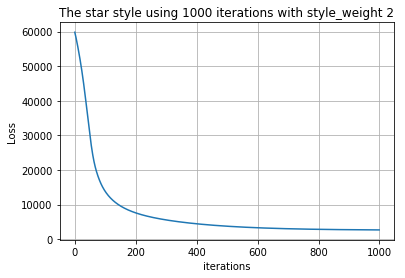

In [5]:
plt.plot(loss_list)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.title('The star style using 1000 iterations with style_weight 2')
plt.grid(True)

#### 1000 iterations using the Ukiyo-e style¶

In [7]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/style.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/kyoto.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 100, 150, 128)
target_features.get_shape() : 
(1, 50, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:62196.187500000
iter:1,loss:61828.968750000
iter:2,loss:61435.898437500
iter:3,loss:61029.187500000
iter:4,loss:60613.148437500
iter:5,loss:60190.343750000
iter:6,loss:59762.269531250
iter:7,loss:59329.894531250
iter:8,loss:58893.777343750
iter:9,loss:58454.234375000
iter:10,loss:58011.257812500
iter:11,loss:57564.945312500
iter:12,loss:57115.027343750
iter:13,loss:56661.449218750
iter:14,loss:56203.914062500
iter:15,loss:55742.187500000
iter:16,loss:55275.824218750
iter:17,loss:54804.539062500
iter:18,loss:54327.914062500
iter:19,loss:53845.539062500
iter:20,loss:53357.015625000
iter:21,loss:52861.898437500
iter:22,loss:52359.863281250
iter:23,loss:51850.468750000
iter:24,loss:51333.390625000
iter:25,loss:5

iter:263,loss:8656.325195312
iter:264,loss:8637.593750000
iter:265,loss:8619.020507812
iter:266,loss:8600.581054688
iter:267,loss:8582.285156250
iter:268,loss:8564.109375000
iter:269,loss:8546.060546875
iter:270,loss:8528.138671875
iter:271,loss:8510.333984375
iter:272,loss:8492.659179688
iter:273,loss:8475.112304688
iter:274,loss:8457.675781250
iter:275,loss:8440.356445312
iter:276,loss:8423.158203125
iter:277,loss:8406.083007812
iter:278,loss:8389.125976562
iter:279,loss:8372.284179688
iter:280,loss:8355.538085938
iter:281,loss:8338.895507812
iter:282,loss:8322.369140625
iter:283,loss:8305.964843750
iter:284,loss:8289.661132812
iter:285,loss:8273.476562500
iter:286,loss:8257.386718750
iter:287,loss:8241.394531250
iter:288,loss:8225.497070312
iter:289,loss:8209.719726562
iter:290,loss:8194.048828125
iter:291,loss:8178.473632812
iter:292,loss:8162.989257812
iter:293,loss:8147.604003906
iter:294,loss:8132.312988281
iter:295,loss:8117.123046875
iter:296,loss:8102.030273438
iter:297,loss:

iter:546,loss:5984.208496094
iter:547,loss:5979.836914062
iter:548,loss:5975.478515625
iter:549,loss:5971.135253906
iter:550,loss:5966.812011719
iter:551,loss:5962.515136719
iter:552,loss:5958.235351562
iter:553,loss:5953.971679688
iter:554,loss:5949.736328125
iter:555,loss:5945.518554688
iter:556,loss:5941.330078125
iter:557,loss:5937.164550781
iter:558,loss:5933.016601562
iter:559,loss:5928.889648438
iter:560,loss:5924.784179688
iter:561,loss:5920.701660156
iter:562,loss:5916.642089844
iter:563,loss:5912.593261719
iter:564,loss:5908.565429688
iter:565,loss:5904.552246094
iter:566,loss:5900.554687500
iter:567,loss:5896.570312500
iter:568,loss:5892.610351562
iter:569,loss:5888.672851562
iter:570,loss:5884.744140625
iter:571,loss:5880.840820312
iter:572,loss:5876.949218750
iter:573,loss:5873.074707031
iter:574,loss:5869.217773438
iter:575,loss:5865.381347656
iter:576,loss:5861.563476562
iter:577,loss:5857.767578125
iter:578,loss:5853.990234375
iter:579,loss:5850.235839844
iter:580,loss:

iter:829,loss:5298.535156250
iter:830,loss:5297.390625000
iter:831,loss:5296.242187500
iter:832,loss:5295.098144531
iter:833,loss:5293.963867188
iter:834,loss:5292.833496094
iter:835,loss:5291.700683594
iter:836,loss:5290.577148438
iter:837,loss:5289.456542969
iter:838,loss:5288.346679688
iter:839,loss:5287.234863281
iter:840,loss:5286.129882812
iter:841,loss:5285.033691406
iter:842,loss:5283.943359375
iter:843,loss:5282.847656250
iter:844,loss:5281.763671875
iter:845,loss:5280.679687500
iter:846,loss:5279.600097656
iter:847,loss:5278.529296875
iter:848,loss:5277.462890625
iter:849,loss:5276.396972656
iter:850,loss:5275.338378906
iter:851,loss:5274.289062500
iter:852,loss:5273.242675781
iter:853,loss:5272.197753906
iter:854,loss:5271.170410156
iter:855,loss:5270.140136719
iter:856,loss:5269.107910156
iter:857,loss:5268.082519531
iter:858,loss:5267.065429688
iter:859,loss:5266.055664062
iter:860,loss:5265.046386719
iter:861,loss:5264.038574219
iter:862,loss:5263.044921875
iter:863,loss:

#### 1000 iterations using The Starry Night style to transfer panda image

In [8]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/panda.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 84, 150, 128)
target_features.get_shape() : 
(1, 42, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:29369.335937500
iter:1,loss:29194.957031250
iter:2,loss:28998.335937500
iter:3,loss:28789.107421875
iter:4,loss:28571.865234375
iter:5,loss:28348.796875000
iter:6,loss:28121.109375000
iter:7,loss:27889.492187500
iter:8,loss:27654.390625000
iter:9,loss:27416.031250000
iter:10,loss:27174.378906250
iter:11,loss:26929.433593750
iter:12,loss:26681.019531250
iter:13,loss:26428.984375000
iter:14,loss:26173.132812500
iter:15,loss:25913.222656250
iter:16,loss:25648.988281250
iter:17,loss:25380.265625000
iter:18,loss:25106.785156250
iter:19,loss:24828.259765625
iter:20,loss:24544.542968750
iter:21,loss:24255.617187500
iter:22,loss:23961.429687500
iter:23,loss:23662.078125000
iter:24,loss:23357.695312500
iter:25,loss:23

iter:265,loss:6034.875000000
iter:266,loss:6010.076660156
iter:267,loss:5985.379394531
iter:268,loss:5960.794433594
iter:269,loss:5936.328613281
iter:270,loss:5911.968750000
iter:271,loss:5887.713378906
iter:272,loss:5863.577148438
iter:273,loss:5839.542968750
iter:274,loss:5815.617675781
iter:275,loss:5791.802246094
iter:276,loss:5768.089843750
iter:277,loss:5744.494140625
iter:278,loss:5721.010253906
iter:279,loss:5697.639648438
iter:280,loss:5674.368652344
iter:281,loss:5651.204589844
iter:282,loss:5628.145019531
iter:283,loss:5605.199707031
iter:284,loss:5582.360351562
iter:285,loss:5559.626953125
iter:286,loss:5537.003906250
iter:287,loss:5514.484375000
iter:288,loss:5492.075195312
iter:289,loss:5469.779785156
iter:290,loss:5447.604980469
iter:291,loss:5425.550292969
iter:292,loss:5403.601562500
iter:293,loss:5381.764648438
iter:294,loss:5360.032226562
iter:295,loss:5338.404296875
iter:296,loss:5316.884277344
iter:297,loss:5295.476562500
iter:298,loss:5274.177734375
iter:299,loss:

iter:548,loss:2807.991943359
iter:549,loss:2805.271972656
iter:550,loss:2802.576904297
iter:551,loss:2799.908447266
iter:552,loss:2797.263183594
iter:553,loss:2794.645996094
iter:554,loss:2792.054687500
iter:555,loss:2789.487548828
iter:556,loss:2786.944580078
iter:557,loss:2784.427246094
iter:558,loss:2781.932128906
iter:559,loss:2779.458740234
iter:560,loss:2777.006103516
iter:561,loss:2774.575195312
iter:562,loss:2772.165771484
iter:563,loss:2769.779052734
iter:564,loss:2767.411132812
iter:565,loss:2765.063476562
iter:566,loss:2762.734375000
iter:567,loss:2760.424560547
iter:568,loss:2758.139160156
iter:569,loss:2755.875000000
iter:570,loss:2753.631591797
iter:571,loss:2751.412109375
iter:572,loss:2749.211181641
iter:573,loss:2747.031738281
iter:574,loss:2744.871337891
iter:575,loss:2742.733398438
iter:576,loss:2740.609375000
iter:577,loss:2738.506591797
iter:578,loss:2736.423828125
iter:579,loss:2734.355957031
iter:580,loss:2732.305908203
iter:581,loss:2730.274902344
iter:582,loss:

iter:831,loss:2509.205566406
iter:832,loss:2508.849853516
iter:833,loss:2508.493164062
iter:834,loss:2508.138671875
iter:835,loss:2507.784667969
iter:836,loss:2507.432861328
iter:837,loss:2507.079589844
iter:838,loss:2506.730224609
iter:839,loss:2506.382324219
iter:840,loss:2506.037109375
iter:841,loss:2505.690673828
iter:842,loss:2505.346679688
iter:843,loss:2505.002929688
iter:844,loss:2504.658203125
iter:845,loss:2504.315673828
iter:846,loss:2503.974609375
iter:847,loss:2503.635498047
iter:848,loss:2503.300292969
iter:849,loss:2502.964843750
iter:850,loss:2502.629394531
iter:851,loss:2502.294677734
iter:852,loss:2501.961914062
iter:853,loss:2501.632812500
iter:854,loss:2501.303955078
iter:855,loss:2500.976806641
iter:856,loss:2500.656005859
iter:857,loss:2500.333984375
iter:858,loss:2500.015380859
iter:859,loss:2499.693847656
iter:860,loss:2499.374023438
iter:861,loss:2499.053710938
iter:862,loss:2498.737792969
iter:863,loss:2498.417480469
iter:864,loss:2498.100097656
iter:865,loss:

### Changing Content_weight to 2 using style_layers_3

In [6]:
STYLE_WEIGHT = 1
CONTENT_WEIGHT = 2
STYLE_LAYERS = ['relu1_2','relu2_2','relu3_2']
CONTENT_LAYERS = ['relu1_2']
_vgg_params = None

def vgg_params():
    global _vgg_params
    if _vgg_params is None:
        _vgg_params = sio.loadmat('/Users/yanting/Downloads/imagenet-vgg-verydeep-19.mat')
    return _vgg_params

def vgg19(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4','pool3',
        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    )

    weights = vgg_params()['layers'][0]
    net = input_image
    network = {}
    for i,name in enumerate(layers):
        layer_type = name[:4]
        if layer_type == 'conv':
            kernels,bias = weights[i][0][0][0][0]
            kernels = np.transpose(kernels,(1,0,2,3))
            conv = tf.nn.conv2d(net,tf.constant(kernels),strides=(1,1,1,1),padding='SAME',name=name)
            net = tf.nn.bias_add(conv,bias.reshape(-1))
            net = tf.nn.relu(net)
        elif layer_type == 'pool':
            net = tf.nn.max_pool(net,ksize=(1,2,2,1),strides=(1,2,2,1),padding='SAME')
        network[name] = net

    return network

def content_loss(target_features,content_features):
    _,height,width,channel = map(lambda i:i.value,content_features.get_shape())
    print ('content_features.get_shape() : ')
    print (content_features.get_shape())
    content_size = height * width * channel
    return tf.nn.l2_loss(target_features - content_features) / content_size

def style_loss(target_features,style_features):
    _,height,width,channel = map(lambda i:i.value,target_features.get_shape())
    print ('target_features.get_shape() : ')
    print (target_features.get_shape())
    size = height * width * channel
    target_features = tf.reshape(target_features,(-1,channel))
    target_gram = tf.matmul(tf.transpose(target_features),target_features) / size

    style_features = tf.reshape(style_features,(-1,channel))
    style_gram = tf.matmul(tf.transpose(style_features),style_features) / size

    return tf.nn.l2_loss(target_gram - style_gram) / size

def loss_function(style_image,content_image,target_image):
    style_features = vgg19([style_image])
    content_features = vgg19([content_image])
    target_features = vgg19([target_image])
    loss = 0.0
    for layer in CONTENT_LAYERS:
        loss += CONTENT_WEIGHT * content_loss(target_features[layer],content_features[layer])

    for layer in STYLE_LAYERS:
        loss += STYLE_WEIGHT * style_loss(target_features[layer],style_features[layer])

    return loss



def stylize(style_image,content_image,learning_rate=0.1,epochs=500):
    cost_list = []
    target = tf.Variable(tf.random_normal(content_image.shape),dtype=tf.float32)
    style_input = tf.constant(style_image,dtype=tf.float32)
    content_input = tf.constant(content_image, dtype=tf.float32)
    cost = loss_function(style_input,content_input,target)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.initialize_all_variables().run()
        for i in range(epochs):
            _,loss,target_image = sess.run([train_op,cost,target])
            print("iter:%d,loss:%.9f" % (i, loss))
            cost_list.append(loss)
            if (i+1) % 100 == 0:
                image = np.clip(target_image + 128,0,255).astype(np.uint8)
                Image.fromarray(image).save("/Users/yanting/Desktop/2040-final/neural_me_%d.jpg" % (i + 1))
    return cost_list

#### 1000 iterations using The Starry Night style

In [7]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/brown.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 121, 300, 64)
target_features.get_shape() : 
(1, 61, 150, 128)
target_features.get_shape() : 
(1, 31, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:66960.851562500
iter:1,loss:66255.898437500
iter:2,loss:65504.695312500
iter:3,loss:64731.312500000
iter:4,loss:63946.597656250
iter:5,loss:63156.234375000
iter:6,loss:62363.855468750
iter:7,loss:61572.125000000
iter:8,loss:60782.636718750
iter:9,loss:59996.515625000
iter:10,loss:59214.882812500
iter:11,loss:58438.480468750
iter:12,loss:57667.750000000
iter:13,loss:56903.218750000
iter:14,loss:56145.253906250
iter:15,loss:55394.148437500
iter:16,loss:54650.222656250
iter:17,loss:53913.621093750
iter:18,loss:53184.460937500
iter:19,loss:52462.812500000
iter:20,loss:51748.820312500
iter:21,loss:51042.468750000
iter:22,loss:50343.835937500
iter:23,loss:49653.011718750
iter:24,loss:48969.906250000
iter:25,loss:48

iter:264,loss:5846.630859375
iter:265,loss:5819.902343750
iter:266,loss:5793.416503906
iter:267,loss:5767.152343750
iter:268,loss:5741.111328125
iter:269,loss:5715.281250000
iter:270,loss:5689.683105469
iter:271,loss:5664.308593750
iter:272,loss:5639.151367188
iter:273,loss:5614.223632812
iter:274,loss:5589.517578125
iter:275,loss:5565.028320312
iter:276,loss:5540.753906250
iter:277,loss:5516.687500000
iter:278,loss:5492.834960938
iter:279,loss:5469.190917969
iter:280,loss:5445.748046875
iter:281,loss:5422.500000000
iter:282,loss:5399.441406250
iter:283,loss:5376.565917969
iter:284,loss:5353.878906250
iter:285,loss:5331.374511719
iter:286,loss:5309.061523438
iter:287,loss:5286.933105469
iter:288,loss:5264.972656250
iter:289,loss:5243.190429688
iter:290,loss:5221.585937500
iter:291,loss:5200.157226562
iter:292,loss:5178.911621094
iter:293,loss:5157.839843750
iter:294,loss:5136.949218750
iter:295,loss:5116.233398438
iter:296,loss:5095.699218750
iter:297,loss:5075.340820312
iter:298,loss:

iter:547,loss:2962.368164062
iter:548,loss:2959.875976562
iter:549,loss:2957.406738281
iter:550,loss:2954.956054688
iter:551,loss:2952.527099609
iter:552,loss:2950.120361328
iter:553,loss:2947.729492188
iter:554,loss:2945.359130859
iter:555,loss:2943.011962891
iter:556,loss:2940.682861328
iter:557,loss:2938.369140625
iter:558,loss:2936.077880859
iter:559,loss:2933.802001953
iter:560,loss:2931.546142578
iter:561,loss:2929.310302734
iter:562,loss:2927.092773438
iter:563,loss:2924.892089844
iter:564,loss:2922.705810547
iter:565,loss:2920.540527344
iter:566,loss:2918.389160156
iter:567,loss:2916.254882812
iter:568,loss:2914.142333984
iter:569,loss:2912.039550781
iter:570,loss:2909.957031250
iter:571,loss:2907.889160156
iter:572,loss:2905.837890625
iter:573,loss:2903.805175781
iter:574,loss:2901.789550781
iter:575,loss:2899.787109375
iter:576,loss:2897.805908203
iter:577,loss:2895.841552734
iter:578,loss:2893.891113281
iter:579,loss:2891.952880859
iter:580,loss:2890.031250000
iter:581,loss:

iter:830,loss:2668.115234375
iter:831,loss:2667.749511719
iter:832,loss:2667.383300781
iter:833,loss:2667.019775391
iter:834,loss:2666.657714844
iter:835,loss:2666.300292969
iter:836,loss:2665.940429688
iter:837,loss:2665.582519531
iter:838,loss:2665.229492188
iter:839,loss:2664.876708984
iter:840,loss:2664.525390625
iter:841,loss:2664.177734375
iter:842,loss:2663.827636719
iter:843,loss:2663.480957031
iter:844,loss:2663.136230469
iter:845,loss:2662.793457031
iter:846,loss:2662.453857422
iter:847,loss:2662.114257812
iter:848,loss:2661.777099609
iter:849,loss:2661.438476562
iter:850,loss:2661.102783203
iter:851,loss:2660.771484375
iter:852,loss:2660.437988281
iter:853,loss:2660.107421875
iter:854,loss:2659.780761719
iter:855,loss:2659.451416016
iter:856,loss:2659.125488281
iter:857,loss:2658.802001953
iter:858,loss:2658.479736328
iter:859,loss:2658.153808594
iter:860,loss:2657.832763672
iter:861,loss:2657.515625000
iter:862,loss:2657.198486328
iter:863,loss:2656.877685547
iter:864,loss:

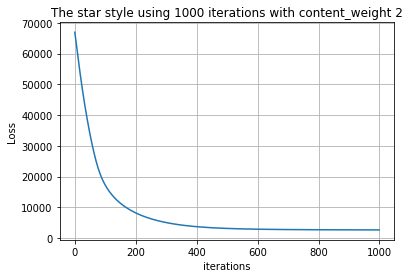

In [8]:
plt.plot(loss_list)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.title('The star style using 1000 iterations with content_weight 2')
plt.grid(True)

#### 1000 iterations using the Ukiyo-e style¶

In [5]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/style.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/kyoto.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 200, 300, 64)
target_features.get_shape() : 
(1, 100, 150, 128)
target_features.get_shape() : 
(1, 50, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:64363.089843750
iter:1,loss:63637.632812500
iter:2,loss:62868.945312500
iter:3,loss:62082.343750000
iter:4,loss:61287.281250000
iter:5,loss:60489.054687500
iter:6,loss:59691.601562500
iter:7,loss:58897.312500000
iter:8,loss:58108.148437500
iter:9,loss:57325.257812500
iter:10,loss:56549.636718750
iter:11,loss:55782.054687500
iter:12,loss:55023.042968750
iter:13,loss:54273.046875000
iter:14,loss:53532.554687500
iter:15,loss:52801.742187500
iter:16,loss:52080.890625000
iter:17,loss:51370.136718750
iter:18,loss:50669.570312500
iter:19,loss:49979.328125000
iter:20,loss:49299.421875000
iter:21,loss:48629.867187500
iter:22,loss:47970.734375000
iter:23,loss:47321.910156250
iter:24,loss:46683.222656250
iter:25,loss:4

iter:263,loss:8170.141601562
iter:264,loss:8146.790039062
iter:265,loss:8123.615722656
iter:266,loss:8100.621093750
iter:267,loss:8077.787597656
iter:268,loss:8055.133789062
iter:269,loss:8032.654296875
iter:270,loss:8010.353515625
iter:271,loss:7988.221191406
iter:272,loss:7966.265625000
iter:273,loss:7944.485351562
iter:274,loss:7922.867187500
iter:275,loss:7901.436523438
iter:276,loss:7880.175781250
iter:277,loss:7859.075195312
iter:278,loss:7838.122558594
iter:279,loss:7817.344726562
iter:280,loss:7796.718261719
iter:281,loss:7776.251953125
iter:282,loss:7755.930664062
iter:283,loss:7735.772460938
iter:284,loss:7715.769042969
iter:285,loss:7695.904296875
iter:286,loss:7676.195800781
iter:287,loss:7656.651855469
iter:288,loss:7637.241210938
iter:289,loss:7617.979492188
iter:290,loss:7598.871093750
iter:291,loss:7579.896972656
iter:292,loss:7561.064453125
iter:293,loss:7542.358398438
iter:294,loss:7523.791992188
iter:295,loss:7505.362792969
iter:296,loss:7487.074218750
iter:297,loss:

iter:546,loss:5476.717773438
iter:547,loss:5474.205566406
iter:548,loss:5471.705078125
iter:549,loss:5469.225585938
iter:550,loss:5466.768066406
iter:551,loss:5464.324218750
iter:552,loss:5461.910156250
iter:553,loss:5459.514648438
iter:554,loss:5457.136718750
iter:555,loss:5454.780273438
iter:556,loss:5452.435058594
iter:557,loss:5450.117675781
iter:558,loss:5447.812500000
iter:559,loss:5445.520507812
iter:560,loss:5443.250488281
iter:561,loss:5441.000976562
iter:562,loss:5438.768554688
iter:563,loss:5436.547851562
iter:564,loss:5434.344238281
iter:565,loss:5432.161621094
iter:566,loss:5429.993164062
iter:567,loss:5427.841796875
iter:568,loss:5425.699218750
iter:569,loss:5423.572753906
iter:570,loss:5421.461914062
iter:571,loss:5419.375000000
iter:572,loss:5417.289550781
iter:573,loss:5415.220703125
iter:574,loss:5413.157226562
iter:575,loss:5411.115234375
iter:576,loss:5409.075195312
iter:577,loss:5407.055664062
iter:578,loss:5405.044921875
iter:579,loss:5403.058593750
iter:580,loss:

iter:829,loss:5150.547851562
iter:830,loss:5150.040039062
iter:831,loss:5149.530761719
iter:832,loss:5149.024414062
iter:833,loss:5148.517578125
iter:834,loss:5148.016113281
iter:835,loss:5147.517578125
iter:836,loss:5147.010742188
iter:837,loss:5146.514160156
iter:838,loss:5146.013183594
iter:839,loss:5145.520019531
iter:840,loss:5145.031250000
iter:841,loss:5144.532226562
iter:842,loss:5144.044921875
iter:843,loss:5143.555664062
iter:844,loss:5143.060058594
iter:845,loss:5142.584472656
iter:846,loss:5142.101562500
iter:847,loss:5141.618164062
iter:848,loss:5141.138671875
iter:849,loss:5140.661621094
iter:850,loss:5140.179687500
iter:851,loss:5139.700683594
iter:852,loss:5139.228515625
iter:853,loss:5138.759765625
iter:854,loss:5138.287597656
iter:855,loss:5137.824218750
iter:856,loss:5137.354492188
iter:857,loss:5136.883789062
iter:858,loss:5136.426757812
iter:859,loss:5135.958007812
iter:860,loss:5135.491699219
iter:861,loss:5135.033203125
iter:862,loss:5134.580078125
iter:863,loss:

#### 1000 iterations using The Starry Night style to transfer panda image

In [6]:
if __name__ == '__main__':
    style = resize('/Users/yanting/Desktop/2040-final/star.jpg')
    style = np.array(style).astype(np.float32) - 128.0
    content = resize('/Users/yanting/Desktop/2040-final/panda.jpg')
    content = np.array(content).astype(np.float32) - 128.0
    loss_list = stylize(style,content,0.5,1000)

content_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 168, 300, 64)
target_features.get_shape() : 
(1, 84, 150, 128)
target_features.get_shape() : 
(1, 42, 75, 256)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
iter:0,loss:37774.988281250
iter:1,loss:37438.792968750
iter:2,loss:37063.671875000
iter:3,loss:36670.523437500
iter:4,loss:36269.324218750
iter:5,loss:35865.089843750
iter:6,loss:35461.019531250
iter:7,loss:35059.253906250
iter:8,loss:34661.292968750
iter:9,loss:34268.230468750
iter:10,loss:33880.976562500
iter:11,loss:33500.152343750
iter:12,loss:33126.144531250
iter:13,loss:32759.404296875
iter:14,loss:32400.208984375
iter:15,loss:32048.666015625
iter:16,loss:31704.933593750
iter:17,loss:31369.035156250
iter:18,loss:31040.998046875
iter:19,loss:30720.736328125
iter:20,loss:30408.191406250
iter:21,loss:30103.169921875
iter:22,loss:29805.589843750
iter:23,loss:29515.205078125
iter:24,loss:29231.785156250
iter:25,loss:28

iter:263,loss:5351.929687500
iter:264,loss:5312.954589844
iter:265,loss:5274.413085938
iter:266,loss:5236.306152344
iter:267,loss:5198.638671875
iter:268,loss:5161.393554688
iter:269,loss:5124.571777344
iter:270,loss:5088.178222656
iter:271,loss:5052.205078125
iter:272,loss:5016.666015625
iter:273,loss:4981.541992188
iter:274,loss:4946.843750000
iter:275,loss:4912.561523438
iter:276,loss:4878.690917969
iter:277,loss:4845.219238281
iter:278,loss:4812.154296875
iter:279,loss:4779.499511719
iter:280,loss:4747.246582031
iter:281,loss:4715.404296875
iter:282,loss:4683.969726562
iter:283,loss:4652.935058594
iter:284,loss:4622.295410156
iter:285,loss:4592.041015625
iter:286,loss:4562.161621094
iter:287,loss:4532.666992188
iter:288,loss:4503.557128906
iter:289,loss:4474.808105469
iter:290,loss:4446.419921875
iter:291,loss:4418.395507812
iter:292,loss:4390.731933594
iter:293,loss:4363.421386719
iter:294,loss:4336.467773438
iter:295,loss:4309.859863281
iter:296,loss:4283.600097656
iter:297,loss:

iter:546,loss:2454.019042969
iter:547,loss:2453.078369141
iter:548,loss:2452.150390625
iter:549,loss:2451.230957031
iter:550,loss:2450.320556641
iter:551,loss:2449.421875000
iter:552,loss:2448.533691406
iter:553,loss:2447.657226562
iter:554,loss:2446.789794922
iter:555,loss:2445.930175781
iter:556,loss:2445.080322266
iter:557,loss:2444.239501953
iter:558,loss:2443.408447266
iter:559,loss:2442.584228516
iter:560,loss:2441.769531250
iter:561,loss:2440.963378906
iter:562,loss:2440.168945312
iter:563,loss:2439.381103516
iter:564,loss:2438.602050781
iter:565,loss:2437.831542969
iter:566,loss:2437.067138672
iter:567,loss:2436.309570312
iter:568,loss:2435.562744141
iter:569,loss:2434.820312500
iter:570,loss:2434.087890625
iter:571,loss:2433.361816406
iter:572,loss:2432.646972656
iter:573,loss:2431.938720703
iter:574,loss:2431.236572266
iter:575,loss:2430.542724609
iter:576,loss:2429.852294922
iter:577,loss:2429.171142578
iter:578,loss:2428.497314453
iter:579,loss:2427.829101562
iter:580,loss:

iter:829,loss:2349.053955078
iter:830,loss:2348.888427734
iter:831,loss:2348.722900391
iter:832,loss:2348.561035156
iter:833,loss:2348.399414062
iter:834,loss:2348.239746094
iter:835,loss:2348.077392578
iter:836,loss:2347.920410156
iter:837,loss:2347.762939453
iter:838,loss:2347.607177734
iter:839,loss:2347.450195312
iter:840,loss:2347.293945312
iter:841,loss:2347.140869141
iter:842,loss:2346.989257812
iter:843,loss:2346.839355469
iter:844,loss:2346.688476562
iter:845,loss:2346.540771484
iter:846,loss:2346.394531250
iter:847,loss:2346.248291016
iter:848,loss:2346.103271484
iter:849,loss:2345.960449219
iter:850,loss:2345.815429688
iter:851,loss:2345.673583984
iter:852,loss:2345.530761719
iter:853,loss:2345.388183594
iter:854,loss:2345.250488281
iter:855,loss:2345.112304688
iter:856,loss:2344.974121094
iter:857,loss:2344.835449219
iter:858,loss:2344.698242188
iter:859,loss:2344.563232422
iter:860,loss:2344.425292969
iter:861,loss:2344.291015625
iter:862,loss:2344.155273438
iter:863,loss: